In [5]:
import folium
import matplotlib.pyplot as plt
import funciones
import csv
import os
import osmnx as ox
import pandas as pd
import networkx as nx
import numpy as np
import re

In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

# Funciones y preprocesamiento de la instancia

In [7]:
# funcion hecha por chat gpt, extrae los numero de un string
def extraer_numeros(texto):
    # Encuentra todos los números en el string y los convierte a enteros
    numeros = [int(num) for num in re.findall(r'\d+', texto)]
    return numeros

# ESTO ENCUENTRAS LAS RUTAS MINIMAS ENTRE CUALQUIER PAR DE NODOS, DA IGUAL SI ES PRODUCCION, ALMACENAJE O DEMANDA
# N son las rutas minimas de los N-primeros arcos del grafo G (de los 1,2...,n arcos)
def rutas_min(grafo: nx.Graph, grafo_ciudad: nx.Graph, N: int):
    lista_pares_nodos = list(grafo.edges())
    dict_info_nodos = dict(grafo_ciudad.nodes(data=True))

    rutas = []
    distancias = []

    for par in range(N):
        parcito = lista_pares_nodos[par]
        O = parcito[0]
        D = parcito[1]

        x_O = dict_info_nodos[O]['x']
        y_O = dict_info_nodos[O]['y']
        
        x_D = dict_info_nodos[D]['x']
        y_D = dict_info_nodos[D]['y']
        
        origen = ox.distance.nearest_nodes(grafo_ciudad, x_O, y_O)
        destino = ox.distance.nearest_nodes(grafo_ciudad, x_D, y_D)

        r = nx.shortest_path(grafo_ciudad, origen, destino, weight='length')
        d = nx.shortest_path_length(grafo_ciudad, origen, destino, weight='length')
        rutas.append(r)
        distancias.append(d)
    
    # rutas son las rutas minimas del arco i del grafo vial, distancias es el largo de la ruta io
    return (rutas,distancias)

# la funcion que grafica rutas minimas
def graficar_rutas_min_n(rutas: list, grafo):
    m2 = ox.folium.plot_graph_folium(grafo.subgraph(rutas[0]), tiles='CartoDB positron', weight= 2)
    for a in range(1, len(rutas)):
        ox.folium.plot_graph_folium(grafo.subgraph(rutas[a]) , graph_map = m2, tiles='CartoDB positron', weight= 2)

    # Guardar mapa como html
    map_file2 = 'Mapa de prueba.html'
    m2.save(map_file2)
    print(f"Mapa guardado en {map_file2}")
    
    return m2

class Node:
    def __init__(self, id, x, y, tipo, numero):
        self.x = x
        self.y = y
        self.id = id
        self.tipo = tipo
        self.numero = numero

In [8]:
RUTA1 = os.path.join('datos','ubicacion_produccion.csv')
RUTA2 = os.path.join('datos',"ubicacion_bodegas_adicionales.csv")
RUTA3 = os.path.join('datos',"ubicacion_demanda.csv")
RUTA4 = os.path.join('datos','precio_venta.csv')
RUTA5 = os.path.join('datos',"oferta_min_proveedores.csv")
RUTA6 = os.path.join('datos',"oferta_max_proveedores.csv")
RUTA7 = os.path.join('datos',"inventario_inicial.csv")
RUTA8 = os.path.join('datos',"inventario_inicial_adicional.csv")
RUTA9 = os.path.join('datos',"demanda_min.csv")
RUTA10 = os.path.join('datos',"demanda_max.csv")
RUTA11 = os.path.join('datos',"costo_produccion.csv")
RUTA12 = os.path.join('datos',"costo_fijo_bodega_adicional.csv")
RUTA13 = os.path.join('datos',"costo_almacenaje_adicional.csv")
RUTA14 = os.path.join('datos',"costo_almacenaje.csv")
RUTA15 = os.path.join('datos',"capacidad_almacenaje.csv")
RUTA16 = os.path.join('datos',"capacidad_almacenaje_adicional.csv")

T = 8
P = 7
B = 18
D = 24

c_tte = 12

lista = []
for i in range(1, T+1):
    lista.append(str(i))

id_prod = []
for a in range(1, P+1):
    id_prod.append(f'P{a}')

id_bod = []
for a in range(1, B+1):
    id_bod.append(f'B{a}')

id_dem = []
for a in range(1, D+1):
    id_dem.append(f'D{a}')

# LECTURA DATOS Y CREACIÓN DE TABLAS
    # PRODUCCION
ubicacion_produccion = pd.read_csv( RUTA1)
oferta_min_proveedores = pd.read_csv( RUTA5)
oferta_max_proveedores = pd.read_csv( RUTA6)
inventario_inicial = pd.read_csv( RUTA7)
costo_produccion = pd.read_csv( RUTA11)
costo_almacenaje = pd.read_csv( RUTA14)
capacidad_almacenaje = pd.read_csv( RUTA15)

    # BODEGAS
ubicacion_bodegas = pd.read_csv( RUTA2)
inventario_inicial_adicional = pd.read_csv( RUTA8)
costo_fijo_bodega_adicional = pd.read_csv( RUTA12)
costo_almacenaje_adicional = pd.read_csv( RUTA13)
capacidad_almacenaje_adicional = pd.read_csv( RUTA16)

    # DEMANDA
ubicacion_demanda = pd.read_csv( RUTA3)
demanda_min = pd.read_csv( RUTA9)
demanda_max = pd.read_csv( RUTA10)
precio_venta = pd.read_csv( RUTA4)


# Se crea un DataFrame combinado con todos los nodos y ubicaciones
nodos_produccion = ubicacion_produccion[['id_nodo', 'x', 'y']].copy()
nodos_produccion['tipo'] = 'produccion'
nodos_produccion['id'] = id_prod


nodos_bodegas = ubicacion_bodegas[['id_nodo', 'x', 'y']].copy()
nodos_bodegas['tipo'] = 'bodega'
nodos_bodegas['id'] = id_bod


nodos_demanda = ubicacion_demanda[['id_nodo', 'x', 'y']].copy()
nodos_demanda['tipo'] = 'demanda'
nodos_demanda['id'] = id_dem


    # CREO TABLAS CON LA INFO DE LOS NODOS EN CADA PERDIODO
        # DEMANDA
precio_venta = precio_venta[lista]
precio_venta['tipo'] = 'demanda'
precio_venta['id'] = id_dem


demanda_min = demanda_min[lista]
demanda_min['tipo'] = 'demanda'
demanda_min['id'] = id_dem

demanda_max = demanda_max[lista]
demanda_max['tipo'] = 'demanda'
demanda_max['id'] = id_dem

        # PRODUCCION
oferta_min_proveedores =oferta_min_proveedores[lista[:-1]]
oferta_min_proveedores['tipo'] = 'produccion'
oferta_min_proveedores['id'] = id_prod

oferta_max_proveedores = oferta_max_proveedores[lista[:-1]]
oferta_max_proveedores['tipo'] = 'produccion'
oferta_max_proveedores['id'] = id_prod

inventario_inicial = inventario_inicial[['1']]
inventario_inicial['tipo'] = 'produccion'
inventario_inicial['id'] = id_prod

costo_produccion = costo_produccion[lista[:-1]]
costo_produccion['tipo'] = 'produccion'
costo_produccion['id'] = id_prod

costo_almacenaje = costo_almacenaje[lista[:-1]]
costo_almacenaje['tipo'] = 'produccion'
costo_almacenaje['id'] = id_prod

capacidad_almacenaje = capacidad_almacenaje[lista[:-1]]
capacidad_almacenaje['tipo'] = 'produccion'
capacidad_almacenaje['id'] = id_prod

        # BODEGAS
inventario_inicial_adicional = inventario_inicial_adicional[['1']]
inventario_inicial_adicional['tipo'] = 'bodega'
inventario_inicial_adicional['id'] = id_bod

costo_fijo_bodega_adicional = costo_fijo_bodega_adicional[['1']]
costo_fijo_bodega_adicional['tipo'] = 'bodega'
costo_fijo_bodega_adicional['id'] = id_bod

costo_almacenaje_adicional = costo_almacenaje_adicional[lista[:-1]]
costo_almacenaje_adicional['tipo'] = 'bodega'
costo_almacenaje_adicional['id'] = id_bod

capacidad_almacenaje_adicional = capacidad_almacenaje_adicional[lista[:-1]]
capacidad_almacenaje_adicional['tipo'] = 'bodega'
capacidad_almacenaje_adicional['id'] = id_bod

# Se combina en un solo DataFrame
nodos_totales = pd.concat([nodos_produccion, nodos_bodegas, nodos_demanda], ignore_index=True)

# Se crea un grafo para representar la red
grafo_vial = nx.Graph()

# Se añaden los nodos al grafo
for _, row in nodos_totales.iterrows():
    grafo_vial.add_node(row['id'], id_nodo=row['id_nodo'], pos=(row['x'], row['y']), tipo=row['tipo'])



# Se añaden los vertices con distancia entre todos los nodos
for i, nodo_i in nodos_totales.iterrows():
    for j, nodo_j in nodos_totales.iterrows():
        if i < j:  # Evitar duplicados
            distancia = np.sqrt((nodo_i['x'] - nodo_j['x'])**2 + (nodo_i['y'] - nodo_j['y'])**2)
            grafo_vial.add_edge(nodo_i['id_nodo'], nodo_j['id_nodo'], weight=distancia)             # creo que esto debería ser con los nodos dentro del mapa - Vale

# Se crea matriz de costos por transporte
nodos_relevantes = list(grafo_vial.nodes)
num_nodos = len(nodos_relevantes)
matriz_distancias = np.zeros((num_nodos, num_nodos))

# RESETEO LOS INDICES
capacidad_almacenaje_adicional = capacidad_almacenaje_adicional.set_index('id')
costo_almacenaje_adicional = costo_almacenaje_adicional.set_index('id')
costo_fijo_bodega_adicional =costo_fijo_bodega_adicional.set_index('id')
inventario_inicial_adicional = inventario_inicial_adicional.set_index('id')
capacidad_almacenaje = capacidad_almacenaje.set_index('id')
costo_almacenaje = costo_almacenaje.set_index('id')
costo_produccion = costo_produccion.set_index('id')
inventario_inicial = inventario_inicial.set_index('id')
oferta_max_proveedores = oferta_max_proveedores.set_index('id')
oferta_min_proveedores = oferta_min_proveedores.set_index('id')
demanda_max = demanda_max.set_index('id')
demanda_min = demanda_min.set_index('id')
nodos_produccion = nodos_produccion.set_index('id')
nodos_bodegas = nodos_bodegas.set_index('id')
nodos_demanda = nodos_demanda.set_index('id')
precio_venta = precio_venta.set_index('id')

# Mapa

In [9]:
north = -41.4
south = -41.496
east = -72.8
west = -73.03

PM = ox.graph_from_bbox(north,south,east,west,network_type='drive')

In [10]:
duplicados = []

for u,v,a in PM.edges(data = True):
  if len(PM[u][v]) == 2:
    duplicados.append((u,v,1))
  elif len(PM[u][v]) == 3:
    duplicados.append((u,v,1))
    duplicados.append((u,v,2))


duplicados = list(dict.fromkeys(duplicados))
PM.remove_edges_from(duplicados)

In [11]:
def setear(filename):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Omitir el encabezado, si existe
        coordenadas = [tuple(map(float, row[1:3])) for row in reader]
    return coordenadas

In [12]:
coordenadas_plantas = setear('datos/ubicacion_produccion.csv')
coordenadas_almacenes = setear('datos/ubicacion_demanda.csv')
coordenadas_bodegas = setear('datos/ubicacion_bodegas_adicionales.csv')

print (coordenadas_plantas)
print(coordenadas_almacenes)
print(coordenadas_bodegas)

[(-72.9049847, -41.4382097), (-72.89773, -41.4616118), (-73.0018052, -41.4748112), (-72.9806647, -41.4723745), (-72.9569328, -41.4269752), (-72.886137, -41.4280949), (-72.9125495, -41.4548131)]
[(-72.9180463, -41.4723684), (-72.9469427, -41.4568804), (-72.9942386, -41.4478807), (-72.9723534, -41.4658041), (-72.9047511, -41.4556736), (-72.989895, -41.478831), (-72.9365376, -41.465138), (-72.9793107, -41.470842), (-72.9192027, -41.4598745), (-72.9708642, -41.4873284), (-72.9229513, -41.4737758), (-72.9237241, -41.4616888), (-72.9144487, -41.4744047), (-72.9690185, -41.4795911), (-72.9703678, -41.4669273), (-72.9420883, -41.4560195), (-72.9723474, -41.4671811), (-72.9100943, -41.4596985), (-72.9988203, -41.4658013), (-72.9911929, -41.4441747), (-72.9113151, -41.4222032), (-72.9172653, -41.4616971), (-72.9911983, -41.4790814), (-72.9037715, -41.4110034)]
[(-72.995677, -41.4626411), (-72.9575967, -41.4735434), (-72.9709703, -41.46606), (-72.9214348, -41.4473181), (-72.9017258, -41.4044988),

In [13]:
def buscar_nodo(grafo, lista_coords):
    nodos = []
    for ubicacion in lista_coords:
        x = ubicacion[0]
        y = ubicacion[1]
        nodo_cercano = ox.nearest_nodes(grafo, x, y)
        nodos.append(nodo_cercano)
    return nodos

In [14]:
n_plantas = buscar_nodo(PM, coordenadas_plantas)
n_almacenes = buscar_nodo(PM, coordenadas_almacenes)
n_bodegas = buscar_nodo(PM, coordenadas_bodegas)

print("Nodos plantas:", n_plantas)
print("Nodos almacenes:", n_almacenes)
print("Nodos bodegas:", n_bodegas)

Nodos plantas: [10827367167, 7564594729, 12119644005, 475560866, 1143298979, 3723703649, 1853718397]
Nodos almacenes: [9261244985, 265016378, 7832735376, 1886717431, 455782369, 476023196, 9569434781, 475560947, 6107982164, 475560777, 267183037, 266902436, 267182640, 476023935, 267456834, 262503262, 8856840317, 266105475, 1784870488, 1840721441, 3663848976, 266907565, 476023188, 1886787603]
Nodos bodegas: [1784870456, 267187616, 1886717444, 321004778, 1893185450, 9476649431, 265325294, 265742684, 9231325097, 3666343193, 4477723612, 3674253932, 4464073565, 7564594723, 1860972990, 3298590271, 476028433, 475563482]


In [15]:
plantas = []

for i in range(len(n_plantas)):
  plantas.append('planta' + str(i+1))


almacenes = []

for i in range(len(n_almacenes)):
  almacenes.append('almacén' + str(i+1))


bodegas = []

for i in range(len(n_bodegas)):
  bodegas.append('bodega' + str(i+1))



In [16]:
for node_id, nuevo_nombre in zip(n_plantas, plantas):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de planta no encontrado en el grafo")

for node_id, nuevo_nombre in zip(n_almacenes, almacenes):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de almacén no encontrado en el grafo")

for node_id, nuevo_nombre in zip(n_bodegas, bodegas):
    if node_id in PM.nodes:
        PM.nodes[node_id]['name'] = nuevo_nombre
    else:
        print(f"Nodo {node_id} de bodega no encontrado en el grafo")

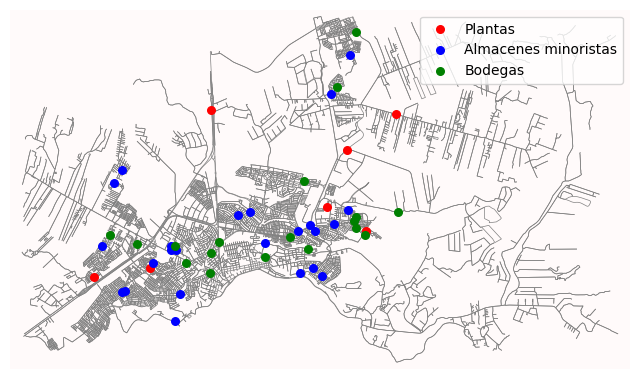

In [17]:
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(PM, node_size=0, edge_color="gray", edge_linewidth=0.5, bgcolor = 'snow', close=False, show=False)


ax.scatter([PM.nodes[node]['x'] for node in n_plantas],
           [PM.nodes[node]['y'] for node in n_plantas],
           c='red', s=30, label="Plantas")

ax.scatter([PM.nodes[node]['x'] for node in n_almacenes],
           [PM.nodes[node]['y'] for node in n_almacenes],
           c='blue', s=30, label="Almacenes minoristas")

ax.scatter([PM.nodes[node]['x'] for node in n_bodegas],
           [PM.nodes[node]['y'] for node in n_bodegas],
           c='green', s=30, label="Bodegas")

plt.legend(loc="upper right")
plt.show()

Definimos diccionarios con el nombr de cada nodo y las coordenadas que nos servirá más adelante para las  

In [18]:
# Crear los diccionarios
map_plantas = {f'planta{i+1}': coord for i, coord in enumerate(coordenadas_plantas)}
map_almacenes = {f'almacen{i+1}': coord for i, coord in enumerate(coordenadas_almacenes)}
map_bodegas = {f'bodega{i+1}': coord for i, coord in enumerate(coordenadas_bodegas)}

# Output de ejemplo
print("map_plantas:", map_plantas)
print("map_almacenes:", map_almacenes)
print("map_bodegas:", map_bodegas)

map_plantas: {'planta1': (-72.9049847, -41.4382097), 'planta2': (-72.89773, -41.4616118), 'planta3': (-73.0018052, -41.4748112), 'planta4': (-72.9806647, -41.4723745), 'planta5': (-72.9569328, -41.4269752), 'planta6': (-72.886137, -41.4280949), 'planta7': (-72.9125495, -41.4548131)}
map_almacenes: {'almacen1': (-72.9180463, -41.4723684), 'almacen2': (-72.9469427, -41.4568804), 'almacen3': (-72.9942386, -41.4478807), 'almacen4': (-72.9723534, -41.4658041), 'almacen5': (-72.9047511, -41.4556736), 'almacen6': (-72.989895, -41.478831), 'almacen7': (-72.9365376, -41.465138), 'almacen8': (-72.9793107, -41.470842), 'almacen9': (-72.9192027, -41.4598745), 'almacen10': (-72.9708642, -41.4873284), 'almacen11': (-72.9229513, -41.4737758), 'almacen12': (-72.9237241, -41.4616888), 'almacen13': (-72.9144487, -41.4744047), 'almacen14': (-72.9690185, -41.4795911), 'almacen15': (-72.9703678, -41.4669273), 'almacen16': (-72.9420883, -41.4560195), 'almacen17': (-72.9723474, -41.4671811), 'almacen18': (-7

# Parte 0: Procesamiento

In [19]:
N = []
for a in range(len(nodos_totales)):
    lista = nodos_totales.loc[a].to_list()
    nodo =  Node(lista[0], lista[1], lista[2], lista[3], lista[4])
    N.append(nodo)

# DICCIONARIO DE ID EN EL MAPA Y EL ID QUE LE PUSE A LOS NODOS

ids = nodos_totales['id_nodo'].to_list()
nombres = nodos_totales['id'].to_list()

dict_ids_nombres = {}

for a in range(len(ids)):
    dict_ids_nombres[ids[a]] = nombres[a]

for a in range(1,7+1):
    nombres.append(f'PB{a}')

In [20]:
# Como se especifica que el transporte es desde los nodos de produccion a bodegas y demanda, y de los nodos
# de bodega  a los nodos de demanda, elimino los arcos que no sirven para del grafo de todos los nodos conectados entre si.

# list(grafo_vial.edges(data=True))[par][origen/destino]
grafo_vial_nuevo = grafo_vial.copy()
lista_pares_nodos = list(grafo_vial_nuevo.edges())

for b in range(len(lista_pares_nodos)):
    a = lista_pares_nodos[b]
    
    O = nodos_totales[nodos_totales['id_nodo'] == a[0]]
    O_pos = O.index[0]

    D = nodos_totales[nodos_totales['id_nodo'] == a[1]]
    D_pos = D.index[0]

    if O['tipo'][O_pos] == D['tipo'][D_pos]:
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos],D['id_nodo'][D_pos])
    
    elif O['tipo'][O_pos] == 'demanda':
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos], D['id_nodo'][D_pos])

info_tipo_nodo = list(dict(grafo_vial_nuevo.nodes(data=True)).values())

In [21]:
# Las rutas minimas entre los nodos (todo el grafo se demora 1 min aprox)
r_min =  rutas_min(grafo_vial_nuevo, PM, len(list(grafo_vial_nuevo.edges())))
#graficar_rutas_min_n(r_min[0], G, 100)

In [22]:
# matriz de costos con las distancias entre los nodos en el mapa
matriz_costos = []
lista_arcos = list(grafo_vial_nuevo.edges(data=True))

for a in range(len(r_min[0])):
    matriz_costos.append([dict_ids_nombres[lista_arcos[a][0]],
                         dict_ids_nombres[lista_arcos[a][1]],
                         r_min[1][a],
                         r_min[0][a]])

In [23]:
matriz_costos_prod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_prod_bod = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_bod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])

for a in matriz_costos:
    if 'P' in a[0]:
        if 'D' in a[1]:
            matriz_costos_prod_dem = matriz_costos_prod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
        elif 'B' in a[1]:
            matriz_costos_prod_bod = matriz_costos_prod_bod._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
    if 'B' in a[0]:
        matriz_costos_bod_dem = matriz_costos_bod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)

In [24]:
I = 7
J = 18+1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_bodegas.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_bodega = pd.DataFrame(data = dict_matriz)


prod_bodega['id'] = list(nodos_produccion.index)

prod_bodega = prod_bodega.set_index('id')

for i in range(len(matriz_costos_prod_bod)):
    fila = matriz_costos_prod_bod.loc[i]['origen']
    columna = matriz_costos_prod_bod.loc[i]['destino']
    guardar = matriz_costos_prod_bod.loc[i]['distancia']
    prod_bodega.loc[fila][columna] = guardar

In [25]:
I = 7
J = 24+1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

prod_demanda = pd.DataFrame(data = dict_matriz)


prod_demanda['id'] = list(nodos_produccion.index)

prod_demanda = prod_demanda.set_index('id')

for i in range(len(matriz_costos_prod_dem)):
    fila = matriz_costos_prod_dem.loc[i]['origen']
    columna = matriz_costos_prod_dem.loc[i]['destino']
    guardar = matriz_costos_prod_dem.loc[i]['distancia']
    prod_demanda.loc[fila][columna] = guardar


In [26]:
I = 18
J = 24+1

# PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
columnas = list(nodos_demanda.index)
filas = []
for a in range(1,I):
    columnas.append(a)
    filas.append(np.float64(0))
filas.append(np.float64(0))

dict_matriz = dict()
for b in range(0,J-1):
    dict_matriz[columnas[b]] = filas

bod_demanda = pd.DataFrame(data = dict_matriz)


bod_demanda['id'] = list(nodos_bodegas.index)

bod_demanda = bod_demanda.set_index('id')

for i in range(len(matriz_costos_bod_dem)):
    fila = matriz_costos_bod_dem.loc[i]['origen']
    columna = matriz_costos_bod_dem.loc[i]['destino']
    guardar = matriz_costos_bod_dem.loc[i]['distancia']
    bod_demanda.loc[fila][columna] = guardar

In [27]:
prod_demanda_distancias = prod_demanda
prod_demanda = round((prod_demanda / 1000) * 12)

prod_bodega_distancias = prod_bodega
prod_bodega = round((prod_bodega / 1000) * 12)

bod_demanda_distancias = bod_demanda
bod_demanda = round((bod_demanda / 1000) * 12)

# Parte I

## Construcción del grafo

In [28]:
G1 = nx.DiGraph()

### Nodos

In [29]:
#se agregan los nodos correspondientes a las tiendas

entra = 0
sale = 0

# EL NODO DE DEMANDA AUXILIAR
for d in range(1, 24+1):
  for t in range(1, 8+1):
    nombre_nodo = 'D_aux' + str(d) + ', t' + str(t)
    demanda = (demanda_max.loc[f'D{d}'][f'{t}']+demanda_min.loc[f'D{d}'][f'{t}'])
    sale += demanda
    G1.add_node(nombre_nodo, demand = demanda)

# Y EL NODO DE DEMANDA
for d in range(1, 24+1):
  for t in range(1, 8+1):
    nombre_nodo = 'D' + str(d) + ', t' + str(t)
    demanda = -demanda_min.loc[f'D{d}'][f'{t}']
    sale += demanda
    G1.add_node(nombre_nodo, demand = demanda)

In [30]:
#se agregan los nodos correspondientes a las fábricas

for p in range(1, 7+1):
  for t in range(1, 8):
    nombre_nodo = 'P' + str(p) + ', t' + str(t)
    oferta = (oferta_max_proveedores.loc[f'P{p}'][f'{t}'] - oferta_min_proveedores.loc[f'P{p}'][f'{t}'])
    entra += oferta
    G1.add_node(nombre_nodo, demand = -oferta)

In [31]:
inv_inicial_fabricas = inventario_inicial.to_dict()['1']
inv_inicial_bodegas = inventario_inicial_adicional.to_dict()['1']

In [32]:
#se agregan los nodos correspondientes a las bodegas de las fábricas

inv_0_fabricas = 0

for i in range(1, 7+1):
  for j in range(1, 8+1):
    nombre_nodo = 'P_bodega' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_fabricas[f'P{i}']
      inv_0_fabricas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [33]:
#se agregan los nodos de bodegas adicionales
inv_0_bodegas = 0

for i in range(1, 5):
  for j in range(1, 8+1):
    nombre_nodo = 'B' + str(i) + ', t' + str(j)
    if j == 1:
      oferta = inv_inicial_bodegas[f'B{i}']
      inv_0_bodegas += oferta
      G1.add_node(nombre_nodo, demand = -oferta)
    else:
      G1.add_node(nombre_nodo)

In [34]:
#se agregan nodos auxiliares para todas las bodegas, tanto de fábricas como bodegas adicionales

for p in range(1, 7+1):
  for j in range(1, 8+1):
    nombre_nodo = f'P_aux{p}, t{j}'
    if j != 1 and j != 8:
      oferta = oferta_min_proveedores.loc[f'P{p}'][f'{j}']
    elif j == 1: 
      oferta = oferta_min_proveedores.loc[f'P{p}'][f'{1}']
    elif j == 8: 
      oferta = 0
  
    G1.add_node(nombre_nodo, demand = -oferta)

for i in range(1, 5):
  for j in range(1, 8+1):
    nombre_nodo = 'B_aux' + str(i) + ', t' + str(j)
    G1.add_node(nombre_nodo)

In [35]:
# vemos cuanto falta para balancear la demanda
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

910


In [36]:
G1.add_node('Sumidero', demand = -suma)

In [37]:
# verificamos que la demanda esta balanceada
suma=0
for a in list(G1.nodes(data=True)):
    if len(a[1])>0:
        suma += a[1]['demand']
print(suma)

0


### Arcos

In [38]:
#se añaden los arcos desde cada fábrica a su nodo auxiliar en todos los periodos

for t in range(1, 8):
  for i in range(1, 7+1):
      nombrefab = 'P' + str(i) + ', t' + str(t)
      nombreaux = 'P_aux' + str(i) + ', t' + str(t)
      costo_prod = costo_produccion.loc[f'P{i}'][f'{t}']
      G1.add_edge(nombrefab, nombreaux, weight = costo_prod)


In [39]:
#se agregan los arcos desde cada bodega de fábrica hasta cada tienda en todos los periodos

for t in range(1, 8+1):
  for b in range(1, 7+1):
    for s in range(1, 24+1):
      costo_trans = prod_demanda.loc[f'P{b}'][f'D{s}']
      p_venta = precio_venta[f'{t}'][f'D{s}']

      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)
      G1.add_edge(nombrebod, nombretienda, weight = costo_trans)

In [40]:
#agregamos el arco que une cada bodega de fábrica con el nodo auxiliar de esa fábrica del mismo periodo

for t in range(1, 8+1):
  for b in range(1, 7+1):
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    G1.add_edge(nombrebod, nombreaux, weight = 0)

In [41]:
#agregamos los arcos que unen el nodo auxiliar de la bodega de una fábrica con el nodo de la misma bodega pero
#en el periodo siguiente

for t in range(1, 8):
  for b in range(1, 7+1):
    nombreaux = 'P_aux' + str(b) + ', t' + str(t)
    nombrebod = 'P_bodega' + str(b) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje.loc[f'P{b}'][f'{t}']
    capacidad_max = capacidad_almacenaje.loc[f'P{b}'][f'{t}']
    G1.add_edge(nombreaux, nombrebod, weight = c_almacenaje, capacity = capacidad_max)

In [42]:
#agregamos arcos desde bodegas de fabricas hasta auxiliares de bodegas adicionales del mismo periodo

for t in range(1, 8+1):
  for b in range(1, 7+1):
    for a in range(1, 5):
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
      costo_trans = prod_bodega.loc[f'P{b}'][f'B{a}']
      G1.add_edge(nombrebod, nombreauxad, weight = costo_trans)

In [43]:
#agregamos arcos  desde nodos auxiliares de bodegas adicionales hasta la misma bodega en el siguiente periodo, para
#todos los periodos y todas las bodegas

for t in range(1, 8):
  for a in range(1, 5):
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    nombrebodad = 'B' + str(a) + ', t' + str(t + 1)
    c_almacenaje = costo_almacenaje_adicional.loc[f'B{a}'][f'{t}']
    capacidad_max = capacidad_almacenaje_adicional.loc[f'B{a}'][f'{t}']
    G1.add_edge(nombreauxad, nombrebodad, weight = c_almacenaje, capacity = capacidad_max)

In [44]:
#agregamos el arco que une cada bodega adicional con el nodo auxiliar de esa bodega adicional del mismo periodo

for t in range(1, 8+1):
  for a in range(1, 5):
    nombrebodad = 'B' + str(a) + ', t' + str(t)
    nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
    G1.add_edge(nombrebodad, nombreauxad, weight = 0)

In [45]:
#agregamos arcos que unen las bodegas adicionales con las tiendas para todos los periodos

for t in range(1, 8+1):
  for s in range(1, 24+1):
    for a in range(1, 5):
      nombrebodad = 'B' + str(a) + ', t' + str(t)
      nombretienda = 'D' + str(s) + ', t' + str(t)

      costo_trans = bod_demanda.loc[f'B{a}'][f'D{s}']

      G1.add_edge(nombrebodad, nombretienda, weight = costo_trans)

In [46]:
# agrego este nodo entre el demanda y demanda auxiliar
for t in range(1, 8+1):
    for a in range(1, 24+1):
      nombrebodad = 'D' + str(a) + ', t' + str(t)
      nombretienda = 'D_aux' + str(a) + ', t' + str(t)

      p_venta = precio_venta[f'{t}'][f'D{s}']

      G1.add_edge(nombrebodad, nombretienda, weight = -p_venta)

In [47]:
#agregamos arcos desde fábricas hasta el sumidero para absorber el exceso de oferta

for t in range(1, 8):
  for f in range(1, 7+1):
    nombrefab = 'P' + str(f) + ', t' + str(t)
    G1.add_edge(nombrefab, 'Sumidero', weight = 0)

In [48]:
#agregamos arcos desde el sumidero hasta las tiendas en caso de que no se cumpla la demanda

for t in range(1, 8+1):
  for s in range(1, 24+1):
    nombretienda = 'D_aux' + str(s) + ', t' + str(t)
    G1.add_edge('Sumidero', nombretienda, weight = 0)

### Solución al problema

In [49]:
sol = nx.min_cost_flow(G1, demand='demand', capacity='capacity', weight='weight')

In [50]:
# CORRER UNA SOLA VEZ ESTA CELDA DE CÓDIGO!!!!!!!!!!!!!!
# EN CASO DE CORRERLA MÁS DE UNA VEZ, POR FAVOR EJECUTAR NUEVAMENTE LA CELDA ANTERIOR 
for a in sol:
    if ('P' in a) and ('P_aux' not in a) and ('P_bod' not in a):
        nodo_productor = a.split(', ')[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        agregar_oferta = oferta_min_proveedores.loc[nodo_productor][f'{periodo}']
        
        oferta_acuatlizada = list(sol[a].values())[0] + agregar_oferta

        sol[a][list(sol[a].keys())[0]] = oferta_acuatlizada

        if sum(list(sol[a].values())) != oferta_max_proveedores.loc[nodo_productor][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

for a in sol:
    if ('D' in a) and ('D_aux' not in a):
        nodo_demandado = a.split(', ')[0]
        nodo_demandon = list(sol[a].keys())[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        quitar_demanda = demanda_min.loc[nodo_demandado][f'{periodo}']
        demanda_acuatlizada = list(sol[a].values())[0] - quitar_demanda

        sol[a][list(sol[a].keys())[0]] = demanda_acuatlizada
        
        if list(sol[a].values())[0] + sol['Sumidero'][nodo_demandon] != demanda_max.loc[nodo_demandado][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

## Construcción de funciones

In [51]:
# Lista con todos los nodos (nombre) y los periodos de tiempo en formato 't...'
bodegas = list(nodos_bodegas.index)
fabricas = list(nodos_produccion.index)
tiendas = list(nodos_demanda.index)

dias = []
for t in range(1, 8+1):
  dias.append('t' + str(t))

fabricas_bodegas = []
fabricas_aux = []
for i in range(1, 7+1):
  fabricas_bodegas.append('P_bodega' + str(i))
  fabricas_aux.append('P_aux' + str(i))

bodegas_aux = []
for i in range(1, 5):
  fabricas_bodegas.append('B_aux' + str(i))

#### Funcion 1

Construcción de una función que reciba como argumentos un periodo de tiempo, y que 
entregue un gráfico que muestre las plantas, bodegas y minoristas, y que ilustre las rutas 
y cargas transportadas entre estos nodos.

Primero, se requiere crear un diccionario que lea los flujos para cada periodo.

In [52]:
flujos_totales = {}

for t in range(1, 9): #itera para cada periodo 1 a 8
    flujos_periodo = {}
    for nodo_origen, subflujos in sol.items():
        #verificar que el nodo esté en el periodo deseado
        if f', t{t}' in nodo_origen:
            #extraer el tipo de nodo y el índice de origen (Todos los P serán planta, todos los B serán bodega y todos los D serán almacén)
            if nodo_origen.startswith("P_aux"):
                tipo_origen = "planta"
                indice_origen = nodo_origen.split("P_aux")[-1].split(',')[0]
            elif nodo_origen.startswith("P_bodega"):
                tipo_origen = "planta"
                indice_origen = nodo_origen.split("P_bodega")[-1].split(',')[0]
            elif nodo_origen.startswith("P"):
                tipo_origen = "planta"
                indice_origen = nodo_origen.split("P")[-1].split(',')[0]
            elif nodo_origen.startswith("B_aux"):
                tipo_origen = "bodega"
                indice_origen = nodo_origen.split("B")[-1].split(',')[0]
            elif nodo_origen.startswith("B"):
                tipo_origen = "bodega"
                indice_origen = nodo_origen.split("B")[-1].split(',')[0]
            elif nodo_origen.startswith("D"):
                tipo_origen = "almacen"
                indice_origen = nodo_origen.split("D")[-1].split(',')[0]
            else:
                continue  # si el nodo no coincide con ningún formato (Sumidero), omitirlo
            
            origen = f"{tipo_origen}{indice_origen}"
            
            for nodo_destino, flujo in subflujos.items():
                if flujo != 0:
                    #lo mismo pero ahora con destinos
                    if nodo_destino.startswith("P_aux"):
                        tipo_destino = "planta"
                        indice_destino = nodo_destino.split("P_aux")[-1].split(',')[0]
                    elif nodo_destino.startswith("P_bodega"):
                        tipo_destino = "planta"
                        indice_destino = nodo_destino.split("P_bodega")[-1].split(',')[0]
                    elif nodo_destino.startswith("P"):
                        tipo_destino = "planta"
                        indice_destino = nodo_destino.split("P")[-1].split(',')[0]
                    elif nodo_destino.startswith("B_aux"):
                        tipo_destino = "bodega"
                        indice_destino = nodo_destino.split("B_aux")[-1].split(',')[0]
                    elif nodo_destino.startswith("B"):
                        tipo_destino = "bodega"
                        indice_destino = nodo_destino.split("B")[-1].split(',')[0]
                    elif nodo_destino.startswith("D"):
                        tipo_destino = "almacen"
                        indice_destino = nodo_destino.split("D")[-1].split(',')[0]
                    else:
                        continue
                    
                    destino = f"{tipo_destino}{indice_destino}"
                    
                    #arco:(o,d) y su flujo
                    arco = (origen, destino)
                    flujos_periodo[arco] = flujo
    flujos_totales[t] = flujos_periodo


In [53]:
def mapa_flujo(G, periodo):
    # Verificar si el periodo tiene datos de flujo
    if periodo not in flujos_totales:
        print(f"Periodo {periodo} no es válido para el periodo productivo")
        return

    flujos_para_periodo = flujos_totales[periodo]

    fig, ax = ox.plot_graph(G, node_size=0, edge_color="gray", edge_linewidth=0.5, bgcolor='white', close=False, show=False)

    #graficamos y asignamos leyenda:
    #plantas
    ax.scatter([], [], c='red', s=50, label='Planta')
    for coord in map_plantas.values():
        ax.scatter(coord[0], coord[1], c='red', s=50)
    #almacenes
    ax.scatter([], [], c='blue', s=50, label='Almacén')
    for coord in map_almacenes.values():
        ax.scatter(coord[0], coord[1], c='blue', s=50)
    #bodegas
    primeras_cuatro_bodegas = list(map_bodegas.items())[:4]
    ax.scatter([], [], c='green', s=50, label='Bodega')
    for _, coord in primeras_cuatro_bodegas:
        ax.scatter(coord[0], coord[1], c='green', s=50)

    #leyenda para las lineas de ruta
    ax.plot([], [], linewidth=1, color='green', label='Flujo ≤ 100')
    ax.plot([], [], linewidth=1.5, color='yellow', label='101 ≤ Flujo ≤ 300')
    ax.plot([], [], linewidth=2, color='orange', label='301 ≤ Flujo ≤ 500')
    ax.plot([], [], linewidth=2.5, color='red', label='Flujo > 500')

    #ruta_min entre dos nodos 
    for (nodo_fuente, nodo_objetivo), cantidad_de_flujo in flujos_para_periodo.items():
        coords_fuente = None
        coords_objetivo = None

        #coordenadas de los nodos fuente y objetivo
        if nodo_fuente in map_plantas:
            coords_fuente = map_plantas[nodo_fuente]
        elif nodo_fuente in map_almacenes:
            coords_fuente = map_almacenes[nodo_fuente]
        elif nodo_fuente in map_bodegas and nodo_fuente in dict(primeras_cuatro_bodegas):
            coords_fuente = map_bodegas[nodo_fuente]

        if nodo_objetivo in map_plantas:
            coords_objetivo = map_plantas[nodo_objetivo]
        elif nodo_objetivo in map_almacenes:
            coords_objetivo = map_almacenes[nodo_objetivo]
        elif nodo_objetivo in map_bodegas and nodo_objetivo in dict(primeras_cuatro_bodegas):
            coords_objetivo = map_bodegas[nodo_objetivo]

        #busvamos la ruta
        if coords_fuente and coords_objetivo:
            try:
                #encuentra el nodo más cercano en el grafo de puerto montt segun las coordenadas
                nodo_grafo_fuente = ox.distance.nearest_nodes(G, coords_fuente[0], coords_fuente[1])
                nodo_grafo_objetivo = ox.distance.nearest_nodes(G, coords_objetivo[0], coords_objetivo[1])

                #obtener ruta mínima entre los nodos origen-destino
                ruta_min = nx.shortest_path(G, source=nodo_grafo_fuente, target=nodo_grafo_objetivo, weight='length')
                
                #obtener las coordenadas de la ruta mínima
                coordenadas_del_camino = [(G.nodes[nodo]['x'], G.nodes[nodo]['y']) for nodo in ruta_min]

                #color y ancho de línea según el flujo
                if cantidad_de_flujo <= 100:
                    ancho_de_linea = 1
                    color = 'green'
                elif cantidad_de_flujo <= 300:
                    ancho_de_linea = 1.5
                    color = 'yellow'
                elif cantidad_de_flujo <= 500:
                    ancho_de_linea = 2
                    color = 'orange'
                else:
                    ancho_de_linea = 2.5
                    color = 'red'

                #dibujamos la linea
                x, y = zip(*coordenadas_del_camino)
                ax.plot(x, y, linewidth=ancho_de_linea, color=color)

            except nx.NetworkXNoPath:
                print(f"No hay un camino entre {nodo_fuente} y {nodo_objetivo} en el grafo.")
        else:
            print(f"Flujo no graficado: Nodo {nodo_fuente} o {nodo_objetivo} tienen la misma ubicacación geográfica.")

    plt.title(f"Rutas y flujo para el período {periodo}")
    plt.axis('off')
    # Leyenda y eliminación de duplicados
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")
    plt.show()


#### Funcion 2

Construir una función que reciba como argumentos una bodega, y que entregue la 
evolución de su nivel de inventario. Esta función también debe permitir hacer este 
análisis en forma agregada para el sistema (es decir, sumado para todas las bodegas)

In [54]:
def preprosecesamiento_para_bodegas(solucion: dict, tipo: str):
    # creo una matriz con ceros para actualizarla segun el inventario
    I=0
    if tipo == 'B':
        I = 18
        pred = 'B_aux'
        tipos_nodo = nodos_bodegas
        inv = inventario_inicial_adicional['1']

    elif tipo == 'P':
        I = 7
        pred = 'P_aux'
        tipos_nodo = nodos_produccion
        inv = inventario_inicial['1']
    
    else:
        print('Los tipos de bodega son:\nB -> bodega adicional\nP->bodega fábrica')
        return
    
    J = 8+1

    # PARÁMETROS COMUNES ENTRE LA MATRIZ DE VIAJES Y COSTOS
    columnas = list(list(range(1,8+1)))
    filas = []
    for a in range(1,I):
        columnas.append(a)
        filas.append(np.float64(0))
    filas.append(np.float64(0))

    dict_matriz = dict()
    for b in range(0,J-1):
        dict_matriz[columnas[b]] = filas

    ppp = pd.DataFrame(data = dict_matriz)
    ppp['id'] = list(tipos_nodo.index)

    ppp = ppp.set_index('id')

    # al dia 1 le pongo el inventario inicial
    ppp[1] = inv


    for a in range(1, 9):
        num_dia = a
        if num_dia == 8:
            dia_actual = dias[num_dia-1]

        else:
            dia_actual = dias[num_dia-1]
            dia_siguiente = dias[num_dia]

        sol_1 = {}

    # saco de sol los nodos que no envian flujo, pongo los nodos que si envian algo en una nuevo diccionario

        for nodo_origen in list(solucion.keys()):
            if dia_actual in nodo_origen:
                if len(solucion[nodo_origen]) != 0:
                    sol_1[nodo_origen] = solucion[nodo_origen]
        sol_2 = {}
        for nodo_origen in list(sol_1.keys()):
            sol_2[nodo_origen] = {}
            for nodo_destino in sol_1[nodo_origen]:
                if sol_1[nodo_origen][nodo_destino] != 0:
                    sol_2[nodo_origen][nodo_destino] = sol_1[nodo_origen][nodo_destino]

        for nodo_origen in (list(sol_2.keys())):
            if pred in nodo_origen:
                for nodo_destino in (list(sol_2[nodo_origen].keys())):
                    if dia_siguiente in nodo_destino:
                        que_nodo_origen =  extraer_numeros(nodo_origen.split(',')[0])[0]
                        cantidad = sol_2[nodo_origen][nodo_destino]
                        ppp[num_dia+1][f'{tipo}{que_nodo_origen}'] = cantidad
                        
                        #print(f'Bodega {que_nodo_origen} guarda {cantidad} dulces para el día {num_dia+1}.')
    return ppp

In [55]:
def nivel_bodegas_fabricas(num_bodega: int, matriz_inventarios: pd.DataFrame):   
    if num_bodega == 0:
        capi = []
        for t in range(1, 8):
            capi.append(capacidad_almacenaje[str(t)].sum())
        print('\n     Día    |       Inventario | Capacidad Máxima')
        print('________________')
        for a in matriz_inventarios.columns:
            inventario = int(matriz_inventarios.sum()[a])
            print(f'''      {a}     |       {inventario} dulces |       {capi[a - 1] if a - 1 < len(capi) else capi[-1]}''')

    else:
        bodega = f'P{num_bodega}'
    
        if bodega not in list(matriz_inventarios.index):
            print('No existe ese número de bodega')
        else:
            capacidad_maxima = capacidad_almacenaje.loc[f'P{num_bodega}'].tolist() + [""]  #vacío para periodo 8
            print('\n     Día    |       Inventario | Capacidad Máxima')
            print('________________')
            for a in matriz_inventarios.columns:
                inventario = int(matriz_inventarios.loc[bodega][a])
                capacidad_actual = capacidad_maxima[a - 1] if a - 1 < len(capacidad_maxima) else ""
                # Verifica si la capacidad actual es numérica
                capacidad_actual = int(capacidad_actual) if str(capacidad_actual).isdigit() else ""
                print(f'''      {a}     |       {inventario} dulces |       {capacidad_actual}''')
            return list(matriz_inventarios.loc[bodega])

def nivel_bodegas_extra(num_bodega: int, matriz_inventarios: pd.DataFrame):
    
    if num_bodega == 0:
        capi = []
        for t in range(1, 8):
            capi.append(capacidad_almacenaje_adicional[str(t)].sum())
        print('\n     Día    |       Inventario | Capacidad Máxima')
        print('________________')
        for a in matriz_inventarios.columns:
            inventario = int(matriz_inventarios.sum()[a])
            print(f'''      {a}     |       {inventario} dulces |       {capi[a - 1] if a - 1 < len(capi) else capi[-1]}''')
        

    else:
        bodega = f'B{num_bodega}'
    
        if bodega not in list(matriz_inventarios.index):
            print('No existe ese número de bodega')
        else:
            capacidad_maxima = capacidad_almacenaje_adicional.loc[f'B{num_bodega}'].tolist() + [""]  
            print('\n     Día    |       Inventario | Capacidad Máxima')
            print('________________')
            for a in matriz_inventarios.columns:
                inventario = int(matriz_inventarios.loc[bodega][a])
                capacidad_actual = capacidad_maxima[a - 1] if a - 1 < len(capacidad_maxima) else ""
                # Verifica si la capacidad actual es numérica
                capacidad_actual = int(capacidad_actual) if str(capacidad_actual).isdigit() else ""
                print(f'''      {a}     |       {inventario} dulces |       {capacidad_actual}''')
            return list(matriz_inventarios.loc[bodega])

In [56]:
# EJECUTAR ESTA CELDA PARA REVISAR UNA BODEGA ADICIONAL
num_bodega1 = 1      # elegir aqui que numero de bodega revisar, si se quieren todas las de un tipo, poner 0
num_bodega2 = 3
matriz_inv = preprosecesamiento_para_bodegas(sol, 'P') # P es si quiero de las bodegas de las fabricas,
                                                       # B si quiero de las bodegas adicionales
matriz_inv_extra = preprosecesamiento_para_bodegas(sol, 'B') 

nivel_bodegas_fabricas(num_bodega1, matriz_inv)
nivel_bodegas_extra(num_bodega2, matriz_inv_extra)



     Día    |       Inventario | Capacidad Máxima
________________
      1     |       501 dulces |       2003
      2     |       663 dulces |       2012
      3     |       1602 dulces |       2012
      4     |       1758 dulces |       2012
      5     |       2002 dulces |       2012
      6     |       2012 dulces |       2012
      7     |       1004 dulces |       1980
      8     |       51 dulces |       

     Día    |       Inventario | Capacidad Máxima
________________
      1     |       0 dulces |       1500
      2     |       0 dulces |       1500
      3     |       0 dulces |       1503
      4     |       0 dulces |       1500
      5     |       1129 dulces |       1500
      6     |       1500 dulces |       1504
      7     |       0 dulces |       1501
      8     |       0 dulces |       


[0.0, 0.0, 0.0, 0.0, 1129.0, 1500.0, 0.0, 0.0]

#### Funcion 3

Construir  una  función  que  construya  un  reporte  de  operación  diaria,  que  indique 
claramente el plan operativo del día, en un formato que podría ser fácilmente entendido 
por el personal responsable de ejecutar las instrucciones.

In [57]:
def imprimir_programacion(num_dia: int):
    if num_dia > 8:
        print('Día fuera del periodo productivo.')

    elif num_dia == 8:
        dia_actual = dias[num_dia-1]
        día_siguiente = dia_actual

    else:
        dia_actual = dias[num_dia-1]
        dia_siguiente = dias[num_dia]

    sol_1 = {}

    # saco de sol los nodos que no envian flujo, pongo los nodos que si envian algo en una nuevo diccionario

    for nodo_origen in list(sol.keys()):
        if dia_actual in nodo_origen:
            if len(sol[nodo_origen]) != 0:
                sol_1[nodo_origen] = sol[nodo_origen]

    sol_2 = {}
    for nodo_origen in list(sol_1.keys()):
        sol_2[nodo_origen] = {}
        for nodo_destino in sol_1[nodo_origen]:
            if sol_1[nodo_origen][nodo_destino] != 0:
                sol_2[nodo_origen][nodo_destino] = sol_1[nodo_origen][nodo_destino]

    # imprimo el tipo de nodo de origen desde el que envio

    for nodo_origen in (list(sol_2.keys())):
        if 'P_aux' not in nodo_origen and 'P_bod' not in nodo_origen and 'P' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'P_aux' in nodo_destino:
                    que_nodo =  extraer_numeros(nodo_origen.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo} produce {cantidad} dulces.')

        if 'P_bodega' in nodo_origen:        
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                que_nodo_origen =  extraer_numeros(nodo_origen.split(',')[0])[0]
                que_nodo_destino =  extraer_numeros(nodo_destino.split(',')[0])[0]

                cantidad = sol_2[nodo_origen][nodo_destino]
                if 'D' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces al almacén {que_nodo_destino}.')
                
                if 'B' in nodo_destino:
                    print(f'Fábrica {que_nodo_origen} envia {cantidad} dulces a la bodega {que_nodo_destino}.')
        
        if 'P_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):            
                if dia_siguiente in nodo_destino:
                    que_nodo_origen =  extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino =  extraer_numeros(nodo_destino.split(',')[0])[0]
                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Fábrica {que_nodo_origen} guarda {cantidad} dulces para el dia siguiente.')
        
        if 'B' in nodo_origen and 'B_aux' not in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if 'D' in nodo_destino:
                    que_nodo_origen =  extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino =  extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Bodega {que_nodo_origen} envia {cantidad} dulces al almacen {que_nodo_destino}.')
        
        if 'B_aux' in nodo_origen:
            for nodo_destino in (list(sol_2[nodo_origen].keys())):
                if dia_siguiente in nodo_destino:
                    que_nodo_origen =  extraer_numeros(nodo_origen.split(',')[0])[0]
                    que_nodo_destino =  extraer_numeros(nodo_destino.split(',')[0])[0]

                    cantidad = sol_2[nodo_origen][nodo_destino]
                    print(f'Bodega {que_nodo_origen} guarda {cantidad} dulces para el día siguiente.')

# Parte II: Análisis

### 1a. Desglose de costos

Desglose de costos totales por transporte, bodegaje, producción y demanda no 
satisfecha. Para esto haremos una función por cada costo con el fin de facilitar el análisis

In [58]:
def calcular_costos_tpte(sol):
    costo_neto_fabricas_demandas = 0
    costo_neto_bodegas_demandas = 0
    costo_neto_fabricas_bodegas = 0
    costo_neto_prod_prod = 0
    costo_neto_bod_bod = 0
    costo_neto_bod_bod_fabrica = 0
    ganancia = 0

    for nodo_origen in sol:
        if 'P_bodega' in nodo_origen:
            numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])[0]
            info_envio = sol[nodo_origen]
            for nodo_destino in info_envio:
                if 'D' in nodo_destino:
                    nombre_nodo_destino = nodo_destino.split(', ')[0]
                    periodo =  extraer_numeros(nodo_destino.split(', ')[1])[0]
                    cantidad = info_envio[nodo_destino]
                    if (f'P{numero_nodo_origen}' in prod_demanda.index) and (nombre_nodo_destino in prod_demanda.columns):
                        costo_envio_unidad = prod_demanda.loc[f'P{numero_nodo_origen}'][nombre_nodo_destino]
                        costo_neto_fabricas_demandas += cantidad * costo_envio_unidad
                        ganancia += cantidad * precio_venta.loc[f'D{periodo}'][f'{periodo}']

        if 'B' in nodo_origen:
            info_envio = sol[nodo_origen]
            nombre_nodo_origen = nodo_origen.split(', ')[0]
            for nodo_destino in info_envio:
                if 'D' in nodo_destino:
                    nombre_nodo_destino = nodo_destino.split(', ')[0]
                    periodo =  extraer_numeros(nodo_destino.split(', ')[1])[0]
                    cantidad = info_envio[nodo_destino]
                    if (nombre_nodo_origen in bod_demanda.index) and (nombre_nodo_destino in bod_demanda.columns):
                        costo_envio_unidad = bod_demanda.loc[nombre_nodo_origen][nombre_nodo_destino]
                        costo_neto_bodegas_demandas += cantidad * costo_envio_unidad
                        ganancia += cantidad * precio_venta.loc[f'D{periodo}'][f'{periodo}']

        if 'P_bodega' in nodo_origen:
            numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])[0]
            info_envio = sol[nodo_origen]
            for nodo_destino in info_envio:
                if 'B_aux' in nodo_destino:
                    numero_nodo_destino =  extraer_numeros(nodo_destino.split(', ')[0])[0]
                    periodo =  extraer_numeros(nodo_destino.split(', ')[1])[0]
                    cantidad = info_envio[nodo_destino]
                    if (f'P{numero_nodo_origen}' in prod_bodega.index) and (f'B{numero_nodo_destino}' in prod_bodega.columns):
                        costo_envio_unidad = prod_bodega.loc[f'P{numero_nodo_origen}'][f'B{numero_nodo_destino}']
                        costo_neto_fabricas_bodegas += cantidad * costo_envio_unidad

        # Arcos entre fábricas
        try:
            if 'P' in nodo_origen and 'P' in nodo_destino:
                numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])[0]
                for nodo_destino in sol[nodo_origen]:
                    numero_nodo_destino =  extraer_numeros(nodo_destino.split(', ')[0])[0]
                    cantidad = sol[nodo_origen][nodo_destino]
                    if (f'P{numero_nodo_origen}' in prod_prod.index) and (f'P{numero_nodo_destino}' in prod_prod.columns):
                        costo_envio_unidad = prod_prod.loc[f'P{numero_nodo_origen}'][f'P{numero_nodo_destino}']
                        costo_neto_prod_prod += cantidad * costo_envio_unidad
        except NameError:
            pass

        # Arcos entre bodegas
        try:
            if 'B' in nodo_origen and 'B' in nodo_destino:
                numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])[0]
                for nodo_destino in sol[nodo_origen]:
                    numero_nodo_destino =  extraer_numeros(nodo_destino.split(', ')[0])[0]
                    cantidad = sol[nodo_origen][nodo_destino]
                    if (f'B{numero_nodo_origen}' in bod_bod.index) and (f'B{numero_nodo_destino}' in bod_bod.columns):
                        costo_envio_unidad = bod_bod.loc[f'B{numero_nodo_origen}'][f'B{numero_nodo_destino}']
                        costo_neto_bod_bod += cantidad * costo_envio_unidad
        except NameError:
            pass

        # Arcos desde bodegas adicionales a bodegas de fábrica
        if 'B' in nodo_origen:
            info_envio = sol[nodo_origen]
            nombre_nodo_origen = nodo_origen.split(', ')[0]
            for nodo_destino in info_envio:
                if 'P_aux' in nodo_destino:
                    numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])[0]
                    numero_nodo_destino =  extraer_numeros(nodo_destino.split(', ')[0])[0]
                    periodo =  extraer_numeros(nodo_destino.split(', ')[1])[0]
                    cantidad = info_envio[nodo_destino]
                    if (f'P{numero_nodo_destino}' in prod_bodega.index) and (f'B{numero_nodo_origen}' in prod_bodega.columns):
                        costo_envio_unidad = prod_bodega.loc[f'P{numero_nodo_destino}'][f'B{numero_nodo_origen}']
                        costo_neto_bod_bod_fabrica += cantidad * costo_envio_unidad

    # Calcular el costo total
    costo_total_tpte = (costo_neto_fabricas_demandas + costo_neto_bodegas_demandas +
                        costo_neto_fabricas_bodegas + costo_neto_prod_prod + 
                        costo_neto_bod_bod + costo_neto_bod_bod_fabrica)

    # Imprimir los resultados
    print(f"Costo de transporte desde plantas a almacenes: {costo_neto_fabricas_demandas}")
    print(f"Costo de transporte desde bodegas a almacenes: {costo_neto_bodegas_demandas}")
    print(f"Costo de transporte desde plantas a bodegas: {costo_neto_fabricas_bodegas}")
    print(f"Costo de transporte entre fábricas: {costo_neto_prod_prod}")
    print(f"Costo de transporte entre bodegas: {costo_neto_bod_bod}")
    print(f"Costo de transporte desde bodegas adicionales a bodegas de fábrica: {costo_neto_bod_bod_fabrica}")
    print(f"Costo total: {costo_total_tpte}")
    print(f"Ganancia total: {ganancia}")

    return (costo_neto_fabricas_demandas, costo_neto_bodegas_demandas,
            costo_neto_fabricas_bodegas, costo_neto_prod_prod,
            costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte)


In [59]:
(costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas, 
 costo_neto_prod_prod, costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte) = calcular_costos_tpte(sol)


Costo de transporte desde plantas a almacenes: 3641331.0
Costo de transporte desde bodegas a almacenes: 103854.0
Costo de transporte desde plantas a bodegas: 409277.0
Costo de transporte entre fábricas: 0
Costo de transporte entre bodegas: 0
Costo de transporte desde bodegas adicionales a bodegas de fábrica: 0
Costo total: 4154462.0
Ganancia total: 28104480


In [60]:
def calcular_costo_produccion(G1, sol):
    costo_produccion = 0

    # p -> p_aux
    for t in range(1, 8):
        for p in range(1, 7+1):
            nodo_origen = f'P{p}, t{t}'
            nodo_destino = f'P_aux{p}, t{t}'

            if sol[nodo_origen] != 0:
                costo_produccion += G1.get_edge_data(nodo_origen, nodo_destino)['weight']

    # Imprimir el costo de producción
    print(f"Costos de producción: {costo_produccion}")

    return costo_produccion

costo_total_produccion = calcular_costo_produccion(G1, sol)

Costos de producción: 9681


In [61]:
# costos por bodegaje:
bod_adicional_en_uso = [False, False, False, False]

def calcular_costos_bodegaje(G1, sol, costo_fijo_bodega_adicional, bod_adicional_en_uso):
    # Inicializamos los costos
    costo_neto_bodegaje_en_fabricas = 0
    costo_neto_bodegaje_en_bodegas_ad = 0
    costo_total_bodegas_ad = 0
    num_bodegas = len(bod_adicional_en_uso)

    # p_aux, t -> p_bod, t+1
    for t in range(1, 8):
        for p in range(1, 7+1):
            nodo_origen = f'P_aux{p}, t{t}'
            nodo_destino = f'P_bodega{p}, t{t+1}'

            if sol[nodo_origen] != 0:
                costo_neto_bodegaje_en_fabricas += G1.get_edge_data(nodo_origen, nodo_destino)['weight']

    # b_aux, t -> b, t+1
    for t in range(1, 8):
        for b in range(1, num_bodegas + 1):
            nodo_origen = f'B_aux{b}, t{t}'
            nodo_destino = f'B{b}, t{t+1}'

            if sol[nodo_origen] != 0:
                bodega_id =  extraer_numeros(list(sol[nodo_origen].keys())[0].split(', ')[0])[0] - 1
                bod_adicional_en_uso[bodega_id] = True
                costo_neto_bodegaje_en_bodegas_ad += G1.get_edge_data(nodo_origen, nodo_destino)['weight']

    # Calcular costo total de bodegas adicionales en uso
    for b in range(num_bodegas):
        if bod_adicional_en_uso[b]:
            costo_total_bodegas_ad += costo_fijo_bodega_adicional.loc[f'B{b+1}']['1']

    # Imprimir los costos
    print(f"El costo total de bodegas adicionales es: {costo_total_bodegas_ad}")
    print(f"El costo neto de bodegaje en fábricas es: {costo_neto_bodegaje_en_fabricas}")
    print(f"El costo neto de bodegaje en bodegas adicionales es: {costo_neto_bodegaje_en_bodegas_ad}")
    print(f"El costo total de bodegaje: {costo_neto_bodegaje_en_bodegas_ad + costo_neto_bodegaje_en_fabricas + costo_total_bodegas_ad }")

    return costo_neto_bodegaje_en_fabricas, costo_neto_bodegaje_en_bodegas_ad, costo_total_bodegas_ad

costo_neto_bodegaje_en_bodegas_ad, costo_neto_bodegaje_en_fabricas, costo_total_bodegas_ad = calcular_costos_bodegaje(G1, sol, costo_fijo_bodega_adicional, bod_adicional_en_uso)
costo_total_bodegaje = costo_neto_bodegaje_en_bodegas_ad + costo_neto_bodegaje_en_fabricas + costo_total_bodegas_ad

El costo total de bodegas adicionales es: 1200000
El costo neto de bodegaje en fábricas es: 1913
El costo neto de bodegaje en bodegas adicionales es: 808
El costo total de bodegaje: 1202721


Costo Total: 5366864.0
Costo Total Transporte: 4154462.0
Costo Total Producción: 9681
Costo Total Bodegaje: 1202721
Las utilidades son 22737616.0


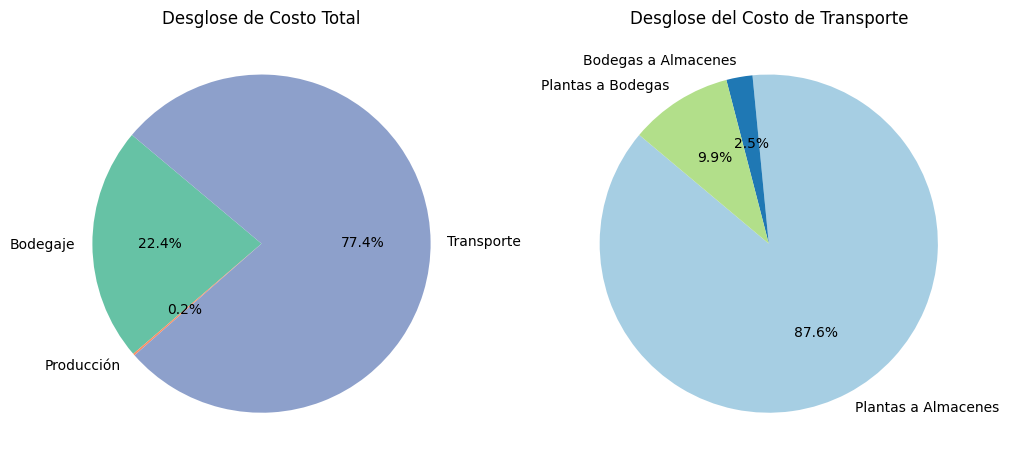

In [62]:
#primer gráfico: desglose de costo_total en bodegaje, producción y transporte
labels_total = ['Bodegaje', 'Producción', 'Transporte']
sizes_total = [costo_total_bodegaje, costo_total_produccion, costo_total_tpte]
colors_total = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.pie(sizes_total, labels=labels_total, autopct='%1.1f%%', startangle=140, colors=colors_total)
plt.title('Desglose de Costo Total')

#segundo gráfico: desglose de costo_total_tpte en subcategorías de transporte
labels_tpte = ['Plantas a Almacenes', 'Bodegas a Almacenes', 'Plantas a Bodegas']
sizes_tpte = [costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas]
colors_tpte = ['#a6cee3', '#1f78b4', '#b2df8a']

plt.subplot(1, 2, 2)
plt.pie(sizes_tpte, labels=labels_tpte, autopct='%1.1f%%', startangle=140, colors=colors_tpte)
plt.title('Desglose del Costo de Transporte')


print(f"Costo Total: {costo_total_tpte+costo_total_produccion+costo_total_bodegaje}")
print(f"Costo Total Transporte: {costo_total_tpte}")
print(f"Costo Total Producción: {costo_total_produccion}")
print(f"Costo Total Bodegaje: {costo_total_bodegaje}")

print(f"Las utilidades son {ganancia -(costo_total_tpte+costo_total_produccion+costo_total_bodegaje) }")

plt.show()




In [63]:
# me dice la demanda q el sumidero esta supliendo, es decir demanda no satisfecha
for a in sol['Sumidero'].keys():
    if sol['Sumidero'][a] !=0:
        print(a+':',sol['Sumidero'][a])

# costos totales totales
nx.cost_of_flow(G1, sol)

D_aux1, t1: 204
D_aux2, t1: 210
D_aux3, t1: 259
D_aux4, t1: 304
D_aux6, t1: 499
D_aux7, t1: 503
D_aux9, t1: 83
D_aux10, t1: 305
D_aux11, t1: 304
D_aux13, t1: 200
D_aux14, t1: 226
D_aux15, t1: 206
D_aux17, t1: 201
D_aux20, t1: 201
D_aux23, t1: 201
D_aux24, t1: 198
D_aux3, t6: 44
D_aux6, t6: 1084
D_aux7, t6: 1299
D_aux10, t6: 1502
D_aux11, t6: 1513
D_aux13, t6: 1103
D_aux15, t6: 906
D_aux20, t6: 1498
D_aux23, t6: 1398
D_aux3, t7: 239
D_aux10, t7: 548
D_aux20, t7: 648


-17933956.0

### 1b. Gráficos de evolución de inventario

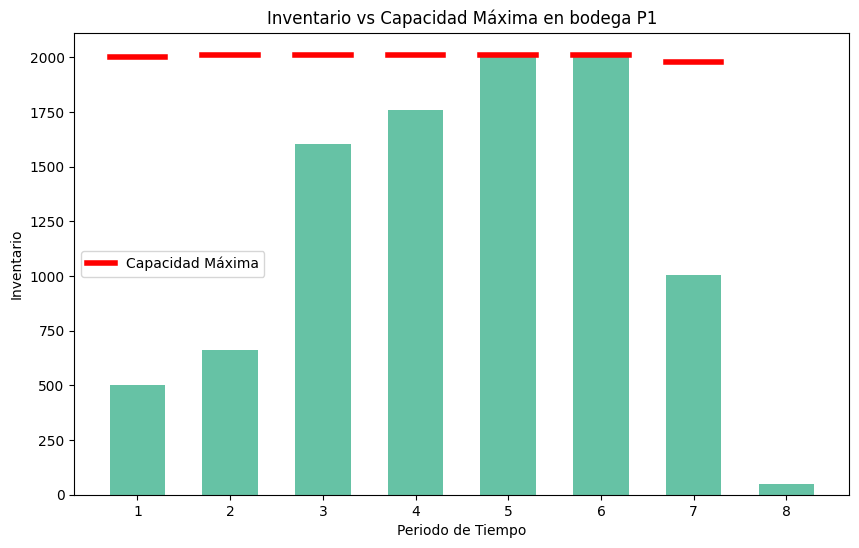

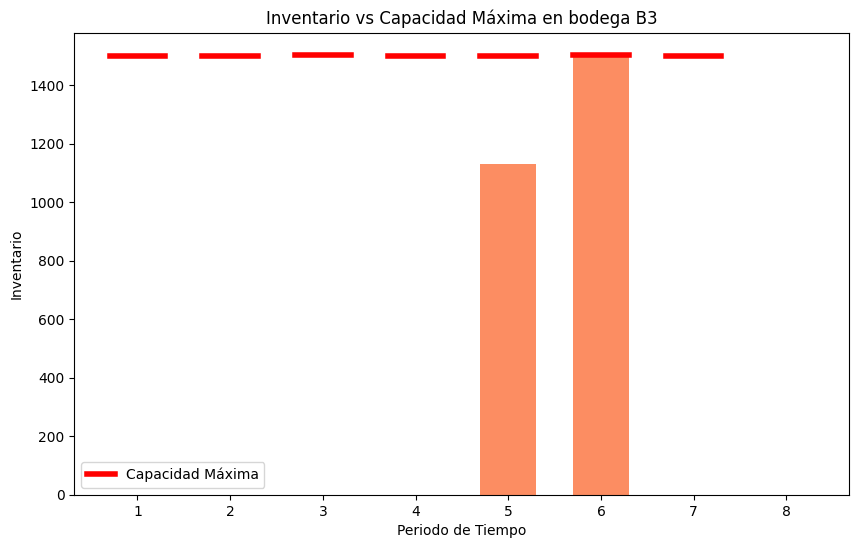

In [64]:
import matplotlib.pyplot as plt

def graficar_inventario_bodega(matriz_inventarios, capacidad_maxima, num_bodega, tipo_bodega, color_barra):
    # Define el prefijo adecuado para el tipo de bodega ('P' para Fábrica y 'B' para Adicional)
    nombre_bodega = f'{tipo_bodega}{num_bodega}' if num_bodega else f'Total {tipo_bodega}'
    periodos = matriz_inventarios.columns.tolist()

    # Si num_bodega es 0, sumar inventarios; de lo contrario, extraer inventario específico
    inventarios = matriz_inventarios.loc[nombre_bodega] if num_bodega else matriz_inventarios.sum()

    plt.figure(figsize=(10, 6))
    plt.bar(periodos, inventarios, color=color_barra, label=f"Inventario {nombre_bodega}", width=0.6)

    # Graficar la línea de capacidad máxima
    for i, cap in enumerate(capacidad_maxima):
        if str(cap).isdigit():  # Asegurarse de que la capacidad máxima es numérica
            plt.plot([periodos[i] - 0.3, periodos[i] + 0.3], [cap, cap], color='red', linewidth=4)

    # Configuración de la gráfica
    plt.xlabel("Periodo de Tiempo")
    plt.ylabel("Inventario")
    plt.title(f"Inventario vs Capacidad Máxima en bodega {nombre_bodega}")
    plt.legend(["Capacidad Máxima"])
    plt.show()

# Colores para cada tipo de bodega
color_fabrica = '#66c2a5'
color_extra = '#fc8d62'

# Graficar inventarios de bodega de fábrica
graficar_inventario_bodega(matriz_inv, capacidad_almacenaje.loc[f'P{num_bodega1}'].tolist() + [""], num_bodega1, 'P', color_fabrica)

# Graficar inventarios de bodega adicional 
#Si queremos graficar otras bodegas, llamar a la función 2 nuevamente con otros numeros
graficar_inventario_bodega(matriz_inv_extra, capacidad_almacenaje_adicional.loc[f'B{num_bodega2}'].tolist() + [""], num_bodega2, 'B', color_extra)



### 1.c ¿Cuando y donde producir?

Hacemos uso de la función 3 definida en la parte 1

In [65]:
for t in range(1, 8+1):
    print(f'\nDÍA {t}')
    imprimir_programacion(t)


DÍA 1
Fábrica 1 produce 663 dulces.
Fábrica 2 produce 403 dulces.
Fábrica 3 produce 1200 dulces.
Fábrica 4 produce 1201 dulces.
Fábrica 5 produce 1540 dulces.
Fábrica 6 produce 2322 dulces.
Fábrica 7 produce 1200 dulces.
Fábrica 1 envia 201 dulces al almacén 5.
Fábrica 1 envia 121 dulces al almacén 9.
Fábrica 1 envia 179 dulces al almacén 12.
Fábrica 2 envia 4 dulces al almacén 5.
Fábrica 2 envia 301 dulces al almacén 18.
Fábrica 3 envia 253 dulces al almacén 8.
Fábrica 3 envia 246 dulces al almacén 19.
Fábrica 4 envia 51 dulces al almacén 8.
Fábrica 5 envia 196 dulces al almacén 2.
Fábrica 5 envia 304 dulces al almacén 16.
Fábrica 6 envia 201 dulces al almacén 21.
Fábrica 6 envia 103 dulces al almacén 24.
Fábrica 7 envia 301 dulces al almacén 22.
Bodega 1 envia 45 dulces al almacen 3.
Bodega 1 envia 55 dulces al almacen 19.
Bodega 2 envia 20 dulces al almacen 14.
Bodega 4 envia 22 dulces al almacen 12.
Fábrica 1 guarda 663 dulces para el dia siguiente.
Fábrica 2 guarda 403 dulces par

Estos flujos, además, podemos visualizarlos en el mapa gracias a la función 1 construida en la parte 1

### 1.d Mapas de flujo para cada periodo

Flujo no graficado: Nodo almacen2 o almacen_aux2 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen3 o almacen_aux3 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen5 o almacen_aux5 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen8 o almacen_aux8 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen9 o almacen_aux9 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen12 o almacen_aux12 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen14 o almacen_aux14 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen16 o almacen_aux16 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen18 o almacen_aux18 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen19 o almacen_aux19 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen21 o almacen_aux21 tienen la misma ubicacación geográfica.
Flujo no 

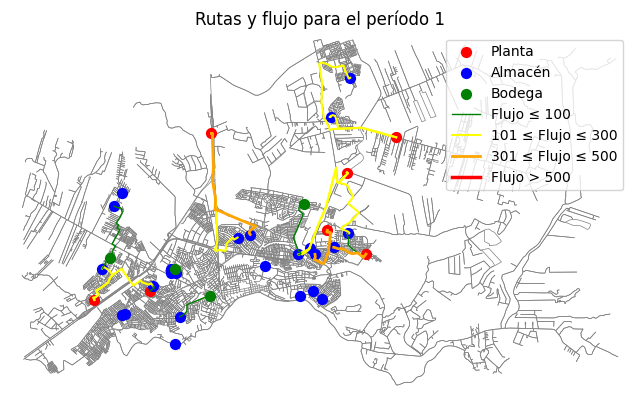

In [66]:
#Ejecutar función con grafo puerto montt y periodo i
mapa_flujo(PM, 1)

Flujo no graficado: Nodo almacen1 o almacen_aux1 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen2 o almacen_aux2 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen3 o almacen_aux3 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen4 o almacen_aux4 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen5 o almacen_aux5 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen6 o almacen_aux6 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen7 o almacen_aux7 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen8 o almacen_aux8 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen9 o almacen_aux9 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen10 o almacen_aux10 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen11 o almacen_aux11 tienen la misma ubicacación geográfica.
Flujo no graficad

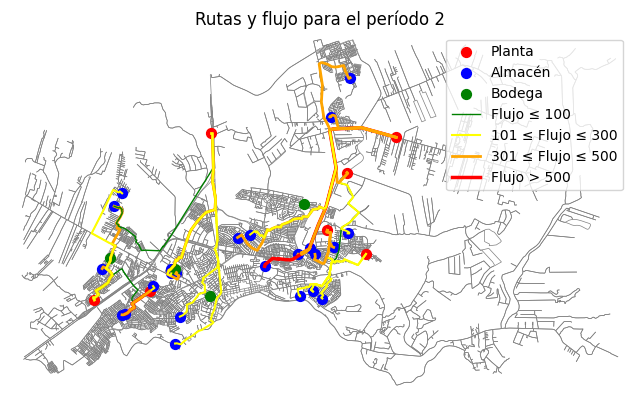

In [67]:
#Ejecutar función con grafo puerto montt y periodo i
mapa_flujo(PM, 2)

Flujo no graficado: Nodo almacen1 o almacen_aux1 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen2 o almacen_aux2 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen3 o almacen_aux3 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen4 o almacen_aux4 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen5 o almacen_aux5 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen6 o almacen_aux6 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen7 o almacen_aux7 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen8 o almacen_aux8 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen9 o almacen_aux9 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen10 o almacen_aux10 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen11 o almacen_aux11 tienen la misma ubicacación geográfica.
Flujo no graficad

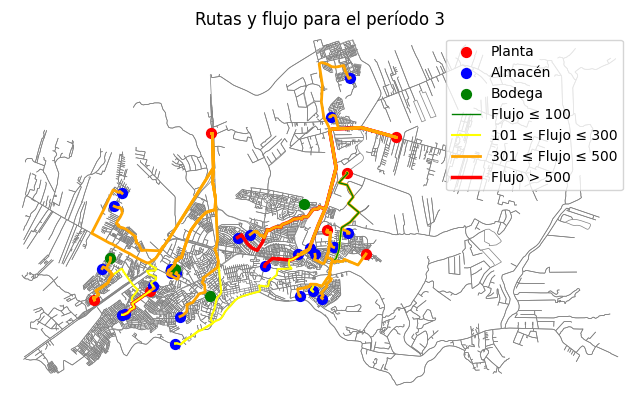

In [68]:
#Ejecutar función con grafo puerto montt y periodo i
mapa_flujo(PM, 3)

Flujo no graficado: Nodo almacen1 o almacen_aux1 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen2 o almacen_aux2 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen3 o almacen_aux3 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen4 o almacen_aux4 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen5 o almacen_aux5 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen6 o almacen_aux6 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen7 o almacen_aux7 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen8 o almacen_aux8 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen9 o almacen_aux9 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen10 o almacen_aux10 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen11 o almacen_aux11 tienen la misma ubicacación geográfica.
Flujo no graficad

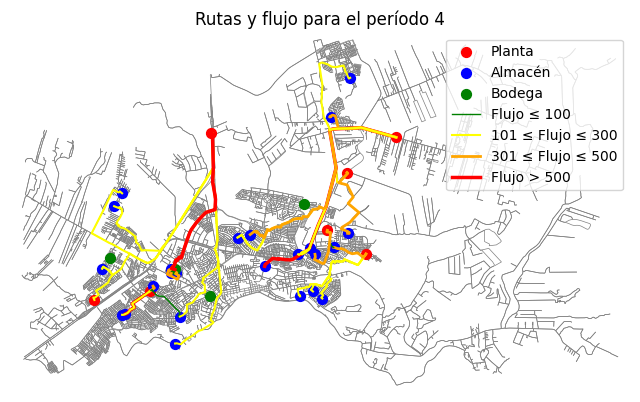

In [69]:
#Ejecutar función con grafo puerto montt y periodo i
mapa_flujo(PM, 4)

Flujo no graficado: Nodo almacen1 o almacen_aux1 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen2 o almacen_aux2 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen3 o almacen_aux3 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen4 o almacen_aux4 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen5 o almacen_aux5 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen6 o almacen_aux6 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen7 o almacen_aux7 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen8 o almacen_aux8 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen9 o almacen_aux9 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen10 o almacen_aux10 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen11 o almacen_aux11 tienen la misma ubicacación geográfica.
Flujo no graficad

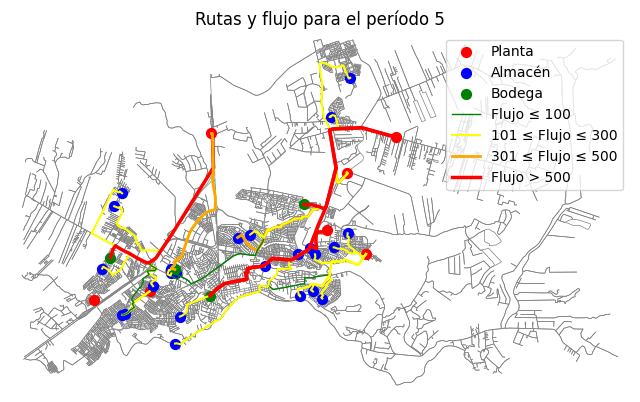

In [70]:
#Ejecutar función con grafo puerto montt y periodo i
mapa_flujo(PM, 5)

Flujo no graficado: Nodo almacen1 o almacen_aux1 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen2 o almacen_aux2 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen3 o almacen_aux3 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen4 o almacen_aux4 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen5 o almacen_aux5 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen6 o almacen_aux6 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen7 o almacen_aux7 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen8 o almacen_aux8 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen9 o almacen_aux9 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen12 o almacen_aux12 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen13 o almacen_aux13 tienen la misma ubicacación geográfica.
Flujo no graficad

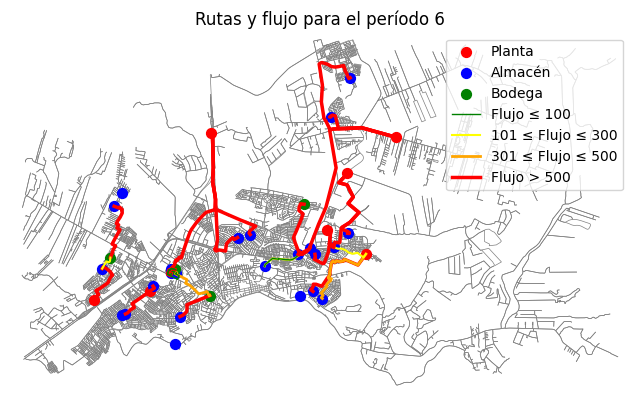

In [71]:
#Ejecutar función con grafo puerto montt y periodo i
mapa_flujo(PM, 6)

Flujo no graficado: Nodo almacen1 o almacen_aux1 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen2 o almacen_aux2 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen3 o almacen_aux3 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen4 o almacen_aux4 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen5 o almacen_aux5 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen6 o almacen_aux6 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen7 o almacen_aux7 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen8 o almacen_aux8 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen9 o almacen_aux9 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen11 o almacen_aux11 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen12 o almacen_aux12 tienen la misma ubicacación geográfica.
Flujo no graficad

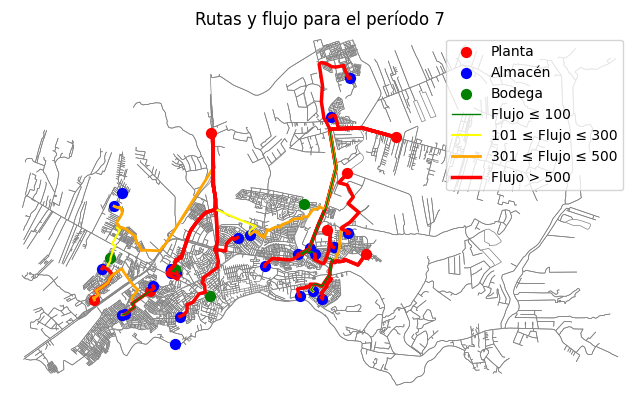

In [72]:
#Ejecutar función con grafo puerto montt y periodo i
mapa_flujo(PM, 7)

Flujo no graficado: Nodo almacen1 o almacen_aux1 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen2 o almacen_aux2 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen3 o almacen_aux3 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen4 o almacen_aux4 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen5 o almacen_aux5 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen6 o almacen_aux6 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen7 o almacen_aux7 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen8 o almacen_aux8 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen9 o almacen_aux9 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen10 o almacen_aux10 tienen la misma ubicacación geográfica.
Flujo no graficado: Nodo almacen11 o almacen_aux11 tienen la misma ubicacación geográfica.
Flujo no graficad

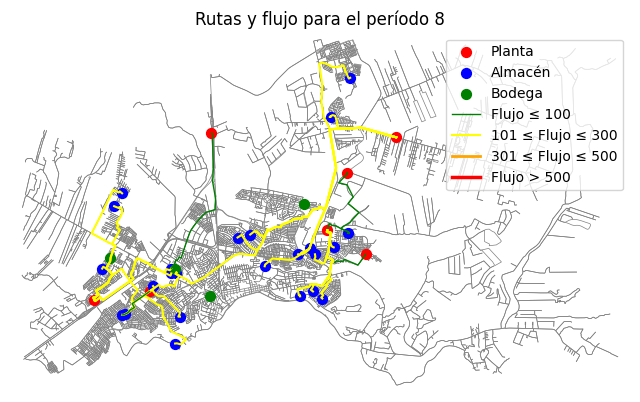

In [73]:
#Ejecutar función con grafo puerto montt y periodo i
mapa_flujo(PM, 8)

### 2. Impacto de agregar arcos bodega - bodega

En primer lugar, sera necesario obtener la matriz de costos para el caso de bodega adicional "i" hacia la bodega adicional "j". Asi mismo, definiremos una nueva matriz de costos que vaya desde bodegas de fabrica hacia otras bodegas de fabrica.
 Para evitar posibles modificaciones en los resultados del codigo anterior, se calcularán las rutas mínimas unicamente para este nuevo caso obteniendo la matriz de costo bodega adicional a bodega adicional.

In [74]:
#cargar el archivo CSV con las coordenadas de las bodegas
bodegas_df = pd.read_csv('./datos/ubicacion_bodegas_adicionales.csv')

#extraemos las bodegas
bodega_nodos = bodegas_df['id_nodo'].tolist()
num_bodegas = len(bodega_nodos)

#inicializar la matriz de distancias comonuna matiz nula
bod_bod = np.zeros((num_bodegas, num_bodegas))

#ruta minima
for i in range(num_bodegas):
    for j in range(i + 1, num_bodegas):
        try:
            distance = nx.shortest_path_length(PM, bodega_nodos[i], bodega_nodos[j], weight='length')
            bod_bod[i, j] = distance
            bod_bod[j, i] = distance  
        except nx.NetworkXNoPath:
            bod_bod[i, j] = np.inf
            bod_bod[j, i] = np.inf

#etiqueta
labels = [f'B{i+1}' for i in range(num_bodegas)]

#dataframe para consistencia con las demás matrices de costo
bod_bod = pd.DataFrame(bod_bod, columns=labels, index=labels)

In [75]:
bod_bod = round((bod_bod/ 1000) * 12)

Ahora, hacemos lo mismo para producción - produccion (Ya que las bodegas de fabrica estan en la misma ubicacion que su produccion)

In [76]:
produccion_df = pd.read_csv('./datos/ubicacion_produccion.csv')


produccion_nodos = produccion_df['id_nodo'].tolist()
num_produccion = len(produccion_nodos)

prod_prod = np.zeros((num_produccion, num_produccion))


for i in range(num_produccion):
    for j in range(i + 1, num_produccion):
        try:
            distance = nx.shortest_path_length(PM, produccion_nodos[i], produccion_nodos[j], weight='length')
            prod_prod[i, j] = distance
            prod_prod[j, i] = distance 
        except nx.NetworkXNoPath:
            prod_prod[i, j] = np.inf
            prod_prod[j, i] = np.inf

prod_labels = [f'P{i+1}' for i in range(num_produccion)]


prod_prod = pd.DataFrame(prod_prod, columns=prod_labels, index=prod_labels)
prod_prod = prod_prod.round()


Con esto listo, habrá que añadir los nuevos arcos bodega-bodega tanto para bodegas ubicadas en las plantas como para bodegas de produccion

In [77]:
#se agregan los arcos desde cada bodega de fábrica hasta la bodega de otra fábrica

for t in range(1, 8+1):
  for b in range(1, 7+1):
    for s in range(1, 7+1):
      if b != s:
        costo_trans = prod_prod.loc[f'P{b}'][f'P{s}']
        nombrebod1 = 'P_bodega' + str(b) + ', t' + str(t)
        nombrebod2 = 'P_aux' + str(s) + ', t' + str(t)
        G1.add_edge(nombrebod1, nombrebod2, weight = costo_trans)

In [78]:
#se agregan los arcos desde cada bodega de fábrica hasta bodega adicional

for t in range(1, 8+1):
    for s in range(1, 18+1):
        for b in range(1,  7+1):
                costo_trans = prod_bodega.loc[f'P{b}'][f'B{s}']
                nombrebod1 = 'P_bodega' + str(b) + ', t' + str(t)
                nombrebod2 = 'B_aux' + str(s) + ', t' + str(t)
                G1.add_edge(nombrebod1, nombrebod2, weight = costo_trans)

In [79]:
#se agregan los arcos desde cada bodega adicional a cada bodega de fábrica 

for t in range(1, 8+1):
    for s in range(1, 7+1):
        for b in range(1, 18+1):
            costo_trans = prod_bodega.loc[f'P{s}', f'B{b}']
            nombrebod1 = 'B' + str(b) + ', t' + str(t)
            nombrebod2 = 'P_aux' + str(s) + ', t' + str(t)
            G1.add_edge(nombrebod1, nombrebod2, weight=costo_trans)



In [80]:
#se agregan los arcos desde cada bodega adicional a otra bodega adicional

for t in range(1, 8+1):
  for b in range(1, 18+1):
    for s in range(1, 18+1):
      if b != s:
        costo_trans = bod_bod.loc[f'B{b}'][f'B{s}']
        nombrebod1 = 'B' + str(b) + ', t' + str(t)
        nombrebod2 = 'B_aux' + str(s) + ', t' + str(t)
        G1.add_edge(nombrebod1, nombrebod2, weight = costo_trans)

In [81]:
sol2 = nx.min_cost_flow(G1, demand='demand', capacity='capacity', weight='weight')

In [82]:
# CORRER UNA SOLA VEZ ESTA CELDA DE CÓDIGO!!!!!!!!!!!!!!
# EN CASO DE CORRERLA MÁS DE UNA VEZ, POR FAVOR EJECUTAR NUEVAMENTE LA CELDA ANTERIOR 
for a in sol2:
    if ('P' in a) and ('P_aux' not in a) and ('P_bod' not in a):
        nodo_productor = a.split(', ')[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        agregar_oferta = oferta_min_proveedores.loc[nodo_productor][f'{periodo}']
        
        oferta_acuatlizada = list(sol2[a].values())[0] + agregar_oferta

        sol2[a][list(sol2[a].keys())[0]] = oferta_acuatlizada

        if sum(list(sol2[a].values())) != oferta_max_proveedores.loc[nodo_productor][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

for a in sol2:
    if ('D' in a) and ('D_aux' not in a):
        nodo_demandado = a.split(', ')[0]
        nodo_demandon = list(sol2[a].keys())[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        quitar_demanda = demanda_min.loc[nodo_demandado][f'{periodo}']
        demanda_acuatlizada = list(sol2[a].values())[0] - quitar_demanda

        sol2[a][list(sol2[a].keys())[0]] = demanda_acuatlizada
        
        if list(sol2[a].values())[0] + sol2['Sumidero'][nodo_demandon] != demanda_max.loc[nodo_demandado][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

In [83]:
(costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas, 
 costo_neto_prod_prod, costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte) = calcular_costos_tpte(sol2)

Costo de transporte desde plantas a almacenes: 3660543.0
Costo de transporte desde bodegas a almacenes: 106506.0
Costo de transporte desde plantas a bodegas: 470901.0
Costo de transporte entre fábricas: 0
Costo de transporte entre bodegas: 353715.0
Costo de transporte desde bodegas adicionales a bodegas de fábrica: 15065.0
Costo total: 4606730.0
Ganancia total: 28294430


In [84]:
costo_total_produccion = calcular_costo_produccion(G1, sol2)

Costos de producción: 9681


In [85]:
calcular_costos_bodegaje(G1, sol2, costo_fijo_bodega_adicional, bod_adicional_en_uso)

El costo total de bodegas adicionales es: 1200000
El costo neto de bodegaje en fábricas es: 1913
El costo neto de bodegaje en bodegas adicionales es: 808
El costo total de bodegaje: 1202721


(1913, 808, 1200000)

Los costos totales son 5819132.0
Las utilidades son: 22475298.0


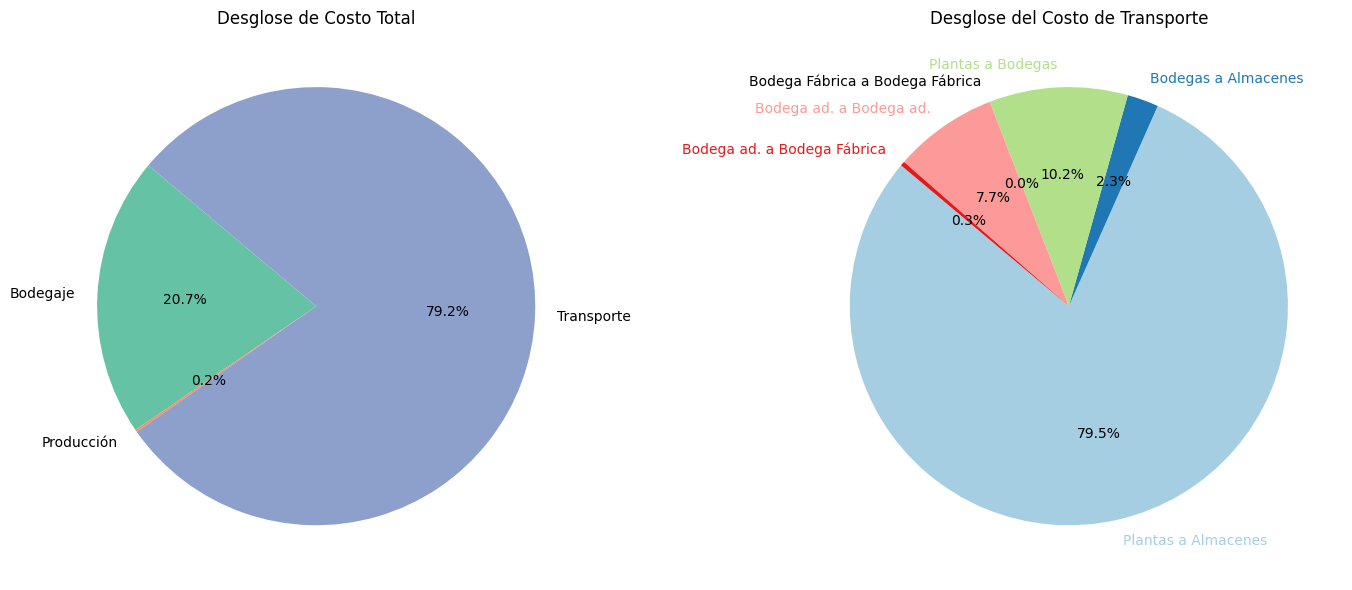

In [86]:
# Primer gráfico: desglose de costo_total en bodegaje, producción y transporte
labels_total = ['Bodegaje', 'Producción', 'Transporte']
sizes_total = [costo_total_bodegaje, costo_total_produccion, costo_total_tpte]
colors_total = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(14, 6))

# Primer gráfico: desglose de costo total
plt.subplot(1, 2, 1)
plt.pie(sizes_total, labels=labels_total, autopct='%1.1f%%', startangle=140, colors=colors_total)
plt.title('Desglose de Costo Total')

# Segundo gráfico: desglose de costo_total_tpte en subcategorías de transporte
labels_tpte = [
    'Plantas a Almacenes', 
    'Bodegas a Almacenes', 
    'Plantas a Bodegas', 
    'Bodega Fábrica a Bodega Fábrica', 
    'Bodega ad. a Bodega ad.', 
    'Bodega ad. a Bodega Fábrica'
]
sizes_tpte = [
    costo_neto_fabricas_demandas, 
    costo_neto_bodegas_demandas, 
    costo_neto_fabricas_bodegas, 
    costo_neto_prod_prod, 
    costo_neto_bod_bod,
    costo_neto_bod_bod_fabrica  # Nuevo costo
]
colors_tpte = ['#a6cee3', '#1f78b4', '#b2df8a', '#000000', '#fb9a99', '#e31a1c']  # 'Bodega Fábrica a Bodega Fábrica' es negro

plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(sizes_tpte, labels=labels_tpte, autopct='%1.1f%%', startangle=140, colors=colors_tpte)
plt.title('Desglose del Costo de Transporte')

# Ajuste de los colores de las etiquetas
for text, color in zip(texts, colors_tpte):
    text.set_color(color)

# Detalle de las nuevas utilidades
print(f"Los costos totales son {costo_total_tpte + costo_total_produccion + costo_total_bodegaje}")
utilidades = ganancia - (costo_total_tpte + costo_total_produccion + costo_total_bodegaje)
print(f"Las utilidades son: {utilidades}")

plt.tight_layout()
plt.show()




Comparando las utilidades iniciales con las utilidades añadiendo estos nuevos arcos tenemos que:

In [87]:
cambio = (22478602.0 - 22739080.0)/22739080.0

if cambio > 0:
    print(f"Las utilidades subieron un {(cambio*100)}%")
else: 
    print(f"Las utilidades bajaron un {(cambio*100)}%")


Las utilidades bajaron un -1.1455080856393487%


### 3. Impacto de abrir nuevas bodegas adicionales

Para este inciso, se utilizará la solución del problema aumentado, es decir considerando los arcos entre bodegas agregados en la parte anterior del análisis

Esta funcion creará un nuevo grafo con los nodos y arcos establecidos en un inicio y agregará solo los nodos y arcos de las bodegas abiertas. Las bodegas abiertas se definirán segun una lista de booleanos que indicará True si la bodega está abierta y False si no, además entregará la solución a dicho grafo.

In [88]:
def tantear_bodega (bodega_en_uso):

  G = nx.DiGraph()

  entra = 0
  sale = 0

  inv_0_fabricas = 0
  inv_0_bodegas = 0

  for i in range(1, 18+1):
    for j in range(1, 8+1):
      nombre_nodo = 'B' + str(i) + ', t' + str(j)
      if bodega_en_uso[i-1] == True:
        if j == 1:
          oferta = inv_inicial_bodegas[f'B{i}']
          inv_0_bodegas += oferta
          G.add_node(nombre_nodo, demand = -oferta)
        else:
          G.add_node(nombre_nodo)
    
  for i in range(1, 18+1):
    for j in range(1, 8+1):
      if bodega_en_uso[i-1] == True:
        nombre_nodo = 'B_aux' + str(i) + ', t' + str(j)
        G.add_node(nombre_nodo)


  for t in range(1, 8+1):
    for b in range(1, 7+1):
      for a in range(1, 18+1):
        if bodega_en_uso[a-1] == True:
          nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
          nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
          costo_trans = prod_bodega.loc[f'P{b}'][f'B{a}']
          G.add_edge(nombrebod, nombreauxad, weight = costo_trans)


  for t in range(1, 8):
    for a in range(1, 18+1):
      if bodega_en_uso[a-1] == True:
        nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
        nombrebodad = 'B' + str(a) + ', t' + str(t + 1)
        c_almacenaje = costo_almacenaje_adicional.loc[f'B{a}'][f'{t}']
        capacidad_max = capacidad_almacenaje_adicional.loc[f'B{a}'][f'{t}']
        G.add_edge(nombreauxad, nombrebodad, weight = c_almacenaje, capacity = capacidad_max)

  #agregamos el arco que une cada bodega adicional con el nodo auxiliar de esa bodega adicional del mismo periodo

  for t in range(1, 8+1):
    for a in range(1, 18 +1):
      if bodega_en_uso[a-1] == True:
        nombrebodad = 'B' + str(a) + ', t' + str(t)
        nombreauxad = 'B_aux' + str(a) + ', t' + str(t)
        G.add_edge(nombrebodad, nombreauxad, weight = 0)


  for t in range(1, 8+1):
    for s in range(1, 24+1):
      for a in range(1, 18+1):
        if bodega_en_uso[a-1] == True:
          nombrebodad = 'B' + str(a) + ', t' + str(t)
          nombretienda = 'D' + str(s) + ', t' + str(t)

          costo_trans = bod_demanda.loc[f'B{a}'][f'D{s}']

          G.add_edge(nombrebodad, nombretienda, weight = costo_trans)

  #Arcos bodega a bodega

  for t in range(1, 8+1):
    for b in range(1, 18+1):
      for s in range(1, 18+1):
        if bodega_en_uso[a-1] == True:
          if b != s:
            costo_trans = bod_bod.loc[f'B{b}'][f'B{s}']
            nombrebod1 = 'B' + str(b) + ', t' + str(t)
            nombrebod2 = 'B_aux' + str(s) + ', t' + str(t)
            G.add_edge(nombrebod1, nombrebod2, weight = costo_trans)

  #se agregan los arcos desde cada bodega adicional a cada bodega de fábrica 

  for t in range(1, 8+1):
      for s in range(1, 7+1):
          for b in range(1, 18+1):
            if bodega_en_uso[a-1] == True:
              costo_trans = prod_bodega.loc[f'P{s}', f'B{b}']
              nombrebod1 = 'B' + str(b) + ', t' + str(t)
              nombrebod2 = 'P_aux' + str(s) + ', t' + str(t)
              G.add_edge(nombrebod1, nombrebod2, weight=costo_trans)

      # EL NODO DE DEMANDA AUXILIAR
  for d in range(1, 24+1):
    for t in range(1, 8+1):
      nombre_nodo = 'D_aux' + str(d) + ', t' + str(t)
      demanda = (demanda_max.loc[f'D{d}'][f'{t}']+demanda_min.loc[f'D{d}'][f'{t}'])
      sale += demanda
      G.add_node(nombre_nodo, demand = demanda)

  # Y EL NODO DE DEMANDA
  for d in range(1, 24+1):
    for t in range(1, 8+1):
      nombre_nodo = 'D' + str(d) + ', t' + str(t)
      demanda = -demanda_min.loc[f'D{d}'][f'{t}']
      sale += demanda
      G.add_node(nombre_nodo, demand = demanda)
  #se agregan los nodos correspondientes a las fábricas

  for p in range(1, 7+1):
    for t in range(1, 8):
      nombre_nodo = 'P' + str(p) + ', t' + str(t)
      oferta = (oferta_max_proveedores.loc[f'P{p}'][f'{t}'] - oferta_min_proveedores.loc[f'P{p}'][f'{t}'])
      entra += oferta
      G.add_node(nombre_nodo, demand = -oferta)

  #se agregan los nodos correspondientes a las bodegas de las fábricas

  for i in range(1, 7+1):
    for j in range(1, 8+1):
      nombre_nodo = 'P_bodega' + str(i) + ', t' + str(j)
      if j == 1:
        oferta = inv_inicial_fabricas[f'P{i}']
        inv_0_fabricas += oferta
        G.add_node(nombre_nodo, demand = -oferta)
      else:
        G.add_node(nombre_nodo)

  #se agregan nodos auxiliares para todas las bodegas, tanto de fábricas como bodegas adicionales

  for p in range(1, 7+1):
    for j in range(1, 8+1):
      nombre_nodo = f'P_aux{p}, t{j}'
      if j != 1 and j != 8:
        oferta = oferta_min_proveedores.loc[f'P{p}'][f'{j}']
      elif j == 1: 
        oferta = oferta_min_proveedores.loc[f'P{p}'][f'{1}']
      elif j == 8: 
        oferta = 0
    
      G.add_node(nombre_nodo, demand = -oferta)

  # vemos cuanto falta para balancear la demanda
  suma=0
  for a in list(G.nodes(data=True)):
      if len(a[1])>0:
          suma += a[1]['demand']
  print(suma)

  G.add_node('Sumidero', demand = -suma)

  # verificamos que la demanda esta balanceada
  suma=0
  for a in list(G.nodes(data=True)):
      if len(a[1])>0:
          suma += a[1]['demand']
  print(f"La suma de las demandas es: {suma}")


  #se añaden los arcos desde cada fábrica a su nodo auxiliar en todos los periodos

  for t in range(1, 8):
    for i in range(1, 7+1):
        nombrefab = 'P' + str(i) + ', t' + str(t)
        nombreaux = 'P_aux' + str(i) + ', t' + str(t)
        costo_prod = costo_produccion.loc[f'P{i}'][f'{t}']
        G.add_edge(nombrefab, nombreaux, weight = costo_prod)


  #se agregan los arcos desde cada bodega de fábrica hasta cada tienda en todos los periodos

  for t in range(1, 8+1):
    for b in range(1, 7+1):
      for s in range(1, 24+1):
        costo_trans = prod_demanda.loc[f'P{b}'][f'D{s}']
        p_venta = precio_venta[f'{t}'][f'D{s}']

        nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
        nombretienda = 'D' + str(s) + ', t' + str(t)
        G.add_edge(nombrebod, nombretienda, weight = costo_trans)


  #agregamos el arco que une cada bodega de fábrica con el nodo auxiliar de esa fábrica del mismo periodo

  for t in range(1, 8+1):
    for b in range(1, 7+1):
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t)
      nombreaux = 'P_aux' + str(b) + ', t' + str(t)
      G.add_edge(nombrebod, nombreaux, weight = 0)


  #agregamos los arcos que unen el nodo auxiliar de la bodega de una fábrica con el nodo de la misma bodega pero
  #en el periodo siguiente

  for t in range(1, 8):
    for b in range(1, 7+1):
      nombreaux = 'P_aux' + str(b) + ', t' + str(t)
      nombrebod = 'P_bodega' + str(b) + ', t' + str(t + 1)
      c_almacenaje = costo_almacenaje.loc[f'P{b}'][f'{t}']
      capacidad_max = capacidad_almacenaje.loc[f'P{b}'][f'{t}']
      G.add_edge(nombreaux, nombrebod, weight = c_almacenaje, capacity = capacidad_max)


  # agrego este nodo entre el demanda y demanda auxiliar
  for t in range(1, 8+1):
      for a in range(1, 24+1):
        nombrebodad = 'D' + str(a) + ', t' + str(t)
        nombretienda = 'D_aux' + str(a) + ', t' + str(t)

        p_venta = precio_venta[f'{t}'][f'D{s}']

        G.add_edge(nombrebodad, nombretienda, weight = -p_venta)

  #agregamos arcos desde fábricas hasta el sumidero para absorber el exceso de oferta

  for t in range(1, 8):
    for f in range(1, 7+1):
      nombrefab = 'P' + str(f) + ', t' + str(t)
      G.add_edge(nombrefab, 'Sumidero', weight = 0)


  #agregamos arcos desde el sumidero hasta las tiendas en caso de que no se cumpla la demanda

  for t in range(1, 8+1):
    for s in range(1, 24+1):
      nombretienda = 'D_aux' + str(s) + ', t' + str(t)
      G.add_edge('Sumidero', nombretienda, weight = 0)
  #se agregan los arcos desde cada bodega de fábrica hasta la bodega de otra fábrica

  for t in range(1, 8+1):
    for b in range(1, 7+1):
      for s in range(1, 7+1):
        if b != s:
          costo_trans = prod_prod.loc[f'P{b}'][f'P{s}']
          nombrebod1 = 'P_bodega' + str(b) + ', t' + str(t)
          nombrebod2 = 'P_aux' + str(s) + ', t' + str(t)
          G.add_edge(nombrebod1, nombrebod2, weight = costo_trans)

    sol = nx.min_cost_flow(G, demand='demand', capacity='capacity', weight='weight')


  return (G, sol)

Además, será necesario definir nuevamente las funciones de costo ya que el numero de nodos de la solución es mayor. Las funciones tienen el mismo funcionamiento que las utilizadas en el desglose de costos solo que estas se adaptan a la cantidad de nodos que tiene el grafo.

In [89]:
def calcular_costos_tpte2(sol):
    costo_neto_fabricas_demandas = 0
    costo_neto_bodegas_demandas = 0
    costo_neto_fabricas_bodegas = 0
    costo_neto_prod_prod = 0
    costo_neto_bod_bod = 0
    costo_neto_bod_bod_fabrica = 0
    ganancia = 0

    for nodo_origen in sol:
        if 'P_bodega' in nodo_origen:
            numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])
            if numero_nodo_origen:  # Verifica que haya al menos un número
                numero_nodo_origen = numero_nodo_origen[0]
                info_envio = sol[nodo_origen]
                for nodo_destino in info_envio:
                    if 'D' in nodo_destino:
                        nombre_nodo_destino = nodo_destino.split(', ')[0]
                        periodo =  extraer_numeros(nodo_destino.split(', ')[1])
                        if periodo:
                            periodo = periodo[0]
                            cantidad = info_envio[nodo_destino]
                            if (f'P{numero_nodo_origen}' in prod_demanda.index) and (nombre_nodo_destino in prod_demanda.columns):
                                costo_envio_unidad = prod_demanda.loc[f'P{numero_nodo_origen}'][nombre_nodo_destino]
                                costo_neto_fabricas_demandas += cantidad * costo_envio_unidad
                                ganancia += cantidad * precio_venta.loc[f'D{periodo}'][f'{periodo}']

        if 'B' in nodo_origen:
            info_envio = sol[nodo_origen]
            nombre_nodo_origen = nodo_origen.split(', ')[0]
            for nodo_destino in info_envio:
                if 'D' in nodo_destino:
                    nombre_nodo_destino = nodo_destino.split(', ')[0]
                    periodo =  extraer_numeros(nodo_destino.split(', ')[1])
                    if periodo:
                        periodo = periodo[0]
                        cantidad = info_envio[nodo_destino]
                        if (nombre_nodo_origen in bod_demanda.index) and (nombre_nodo_destino in bod_demanda.columns):
                            costo_envio_unidad = bod_demanda.loc[nombre_nodo_origen][nombre_nodo_destino]
                            costo_neto_bodegas_demandas += cantidad * costo_envio_unidad
                            ganancia += cantidad * precio_venta.loc[f'D{periodo}'][f'{periodo}']

        if 'P_bodega' in nodo_origen:
            numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])
            if numero_nodo_origen:
                numero_nodo_origen = numero_nodo_origen[0]
                info_envio = sol[nodo_origen]
                for nodo_destino in info_envio:
                    if 'B_aux' in nodo_destino:
                        numero_nodo_destino =  extraer_numeros(nodo_destino.split(', ')[0])
                        periodo =  extraer_numeros(nodo_destino.split(', ')[1])
                        if numero_nodo_destino and periodo:
                            numero_nodo_destino = numero_nodo_destino[0]
                            periodo = periodo[0]
                            cantidad = info_envio[nodo_destino]
                            if (f'P{numero_nodo_origen}' in prod_bodega.index) and (f'B{numero_nodo_destino}' in prod_bodega.columns):
                                costo_envio_unidad = prod_bodega.loc[f'P{numero_nodo_origen}'][f'B{numero_nodo_destino}']
                                costo_neto_fabricas_bodegas += cantidad * costo_envio_unidad

        # Arcos entre fábricas
        if 'P' in nodo_origen:
            numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])
            if numero_nodo_origen:
                numero_nodo_origen = numero_nodo_origen[0]
                for nodo_destino in sol[nodo_origen]:
                    numero_nodo_destino =  extraer_numeros(nodo_destino.split(', ')[0])
                    if numero_nodo_destino:
                        numero_nodo_destino = numero_nodo_destino[0]
                        cantidad = sol[nodo_origen][nodo_destino]
                        if (f'P{numero_nodo_origen}' in prod_prod.index) and (f'P{numero_nodo_destino}' in prod_prod.columns):
                            costo_envio_unidad = prod_prod.loc[f'P{numero_nodo_origen}'][f'P{numero_nodo_destino}']
                            costo_neto_prod_prod += cantidad * costo_envio_unidad
                            costo_neto_prod_prod = 0

        # Arcos entre bodegas
        if 'B' in nodo_origen:
            numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])
            if numero_nodo_origen:
                numero_nodo_origen = numero_nodo_origen[0]
                for nodo_destino in sol[nodo_origen]:
                    numero_nodo_destino =  extraer_numeros(nodo_destino.split(', ')[0])
                    if numero_nodo_destino:
                        numero_nodo_destino = numero_nodo_destino[0]
                        cantidad = sol[nodo_origen][nodo_destino]
                        if (f'B{numero_nodo_origen}' in bod_bod.index) and (f'B{numero_nodo_destino}' in bod_bod.columns):
                            costo_envio_unidad = bod_bod.loc[f'B{numero_nodo_origen}'][f'B{numero_nodo_destino}']
                            costo_neto_bod_bod += cantidad * costo_envio_unidad

        # Arcos desde bodegas adicionales a bodegas de fábrica
        if 'B' in nodo_origen:
            info_envio = sol[nodo_origen]
            nombre_nodo_origen = nodo_origen.split(', ')[0]
            for nodo_destino in info_envio:
                if 'P_aux' in nodo_destino:
                    numero_nodo_origen =  extraer_numeros(nodo_origen.split(', ')[0])
                    numero_nodo_destino =  extraer_numeros(nodo_destino.split(', ')[0])
                    periodo =  extraer_numeros(nodo_destino.split(', ')[1])
                    if numero_nodo_origen and numero_nodo_destino and periodo:
                        numero_nodo_origen = numero_nodo_origen[0]
                        numero_nodo_destino = numero_nodo_destino[0]
                        periodo = periodo[0]
                        cantidad = info_envio[nodo_destino]
                        if (f'P{numero_nodo_destino}' in prod_bodega.index) and (f'B{numero_nodo_origen}' in prod_bodega.columns):
                            costo_envio_unidad = prod_bodega.loc[f'P{numero_nodo_destino}'][f'B{numero_nodo_origen}']
                            costo_neto_bod_bod_fabrica += cantidad * costo_envio_unidad

    # Calcular el costo total
    costo_total_tpte = (costo_neto_fabricas_demandas + costo_neto_bodegas_demandas +
                        costo_neto_fabricas_bodegas + costo_neto_prod_prod + 
                        costo_neto_bod_bod + costo_neto_bod_bod_fabrica)

    # Imprimir los resultados
    print(f"Costo de transporte desde plantas a almacenes: {costo_neto_fabricas_demandas}")
    print(f"Costo de transporte desde bodegas a almacenes: {costo_neto_bodegas_demandas}")
    print(f"Costo de transporte desde plantas a bodegas: {costo_neto_fabricas_bodegas}")
    print(f"Costo de transporte entre fábricas: {costo_neto_prod_prod}")
    print(f"Costo de transporte entre bodegas: {costo_neto_bod_bod}")
    print(f"Costo de transporte desde bodegas adicionales a bodegas de fábrica: {costo_neto_bod_bod_fabrica}")
    print(f"Costo total: {costo_total_tpte}")
    print(f"Ganancia total: {ganancia}")

    return (costo_neto_fabricas_demandas, costo_neto_bodegas_demandas,
            costo_neto_fabricas_bodegas, costo_neto_prod_prod,
            costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte)

def calcular_costo_produccion2(G, sol):
    costo_produccion = 0

    # Iterar sobre todos los nodos en `sol` para buscar nodos con el patrón 'P' -> 'P_aux'
    for nodo_origen in sol:
        # Verificar que el nodo origen sigue el patrón 'P#' y destino es 'P_aux#'
        if nodo_origen.startswith('P') and nodo_origen.split(', ')[0].replace('P', '').isdigit():
            numero_p = nodo_origen.split(', ')[0].replace('P', '')
            tiempo = nodo_origen.split(', ')[1]
            nodo_destino = f'P_aux{numero_p}, {tiempo}'

            # Comprobar que el arco existe en el grafo y que hay un valor distinto de cero en `sol`
            if nodo_destino in sol.get(nodo_origen, {}) and sol[nodo_origen][nodo_destino] != 0:
                # Sumar el peso del arco a `costo_produccion`
                costo_produccion += G.get_edge_data(nodo_origen, nodo_destino).get('weight', 0)

    # Imprimir el costo de producción
    print(f"Costos de producción: {costo_produccion}")

    return costo_produccion

def calcular_costos_bodegaje2(G, sol, costo_fijo_bodega_adicional, bod_adicional_en_uso):
    # Inicializamos los costos
    costo_neto_bodegaje_en_fabricas = 0
    costo_neto_bodegaje_en_bodegas_ad = 0
    costo_total_bodegas_ad = 0
    num_bodegas = len(bod_adicional_en_uso)

    # Iteración para calcular costos de bodegaje en fábricas: p_aux, t -> p_bod, t+1
    for t in range(1, 8):
        for p in range(1, 7+1):
            nodo_origen = f'P_aux{p}, t{t}'
            nodo_destino = f'P_bodega{p}, t{t+1}'

            if sol.get(nodo_origen, 0) != 0 and G.has_edge(nodo_origen, nodo_destino):
                costo_neto_bodegaje_en_fabricas += G.get_edge_data(nodo_origen, nodo_destino).get('weight', 0)

    # Iteración para calcular costos de bodegaje en bodegas adicionales: b_aux, t -> b, t+1
    for t in range(1, 8):
        for b in range(1, num_bodegas + 1):
            nodo_origen = f'B_aux{b}, t{t}'
            nodo_destino = f'B{b}, t{t+1}'

            if sol.get(nodo_origen, 0) != 0 and G.has_edge(nodo_origen, nodo_destino):
                costo_neto_bodegaje_en_bodegas_ad += G.get_edge_data(nodo_origen, nodo_destino).get('weight', 0)

    # Calcular el costo total de bodegas adicionales en uso, basado en `bod_adicional_en_uso`
    for b in range(num_bodegas):
        if bod_adicional_en_uso[b]:
            costo_total_bodegas_ad += costo_fijo_bodega_adicional.loc[f'B{b+1}']['1']

    # Imprimir los costos
    print(f"El costo total de bodegas adicionales es: {costo_total_bodegas_ad}")
    print(f"El costo neto de bodegaje en fábricas es: {costo_neto_bodegaje_en_fabricas}")
    print(f"El costo neto de bodegaje en bodegas adicionales es: {costo_neto_bodegaje_en_bodegas_ad}")
    print(f"El costo total de bodegaje: {costo_neto_bodegaje_en_bodegas_ad + costo_neto_bodegaje_en_fabricas + costo_total_bodegas_ad}")

    return costo_neto_bodegaje_en_fabricas, costo_neto_bodegaje_en_bodegas_ad, costo_total_bodegas_ad


### Abrir las dos bodegas de menor costos fijo (200.000)

Primero veremos el costo de abrir solo dos bodegas adicionales, eligeremos las de menor costo fijo con el fin de minimizar costos

Viendo los datos, la de menor costo es la 5 y la 15 asi que probaremos, en un inicio con esas dos.

In [90]:
bodega_en_uso = [False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False ]

G3, sol3 = tantear_bodega (bodega_en_uso)

for a in sol3:
    if ('P' in a) and ('P_aux' not in a) and ('P_bod' not in a):
        nodo_productor = a.split(', ')[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        agregar_oferta = oferta_min_proveedores.loc[nodo_productor][f'{periodo}']
        
        oferta_acuatlizada = list(sol3[a].values())[0] + agregar_oferta

        sol3[a][list(sol3[a].keys())[0]] = oferta_acuatlizada

        if sum(list(sol3[a].values())) != oferta_max_proveedores.loc[nodo_productor][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

for a in sol3:
    if ('D' in a) and ('D_aux' not in a):
        nodo_demandado = a.split(', ')[0]
        nodo_demandon = list(sol3[a].keys())[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        quitar_demanda = demanda_min.loc[nodo_demandado][f'{periodo}']
        demanda_acuatlizada = list(sol3[a].values())[0] - quitar_demanda

        sol3[a][list(sol3[a].keys())[0]] = demanda_acuatlizada
        
        if list(sol3[a].values())[0] + sol3['Sumidero'][nodo_demandon] != demanda_max.loc[nodo_demandado][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

902
La suma de las demandas es: 0


In [91]:
(costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas, 
 costo_neto_prod_prod, costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte) = calcular_costos_tpte2(sol3)

Costo de transporte desde plantas a almacenes: 3692458.0
Costo de transporte desde bodegas a almacenes: 90384.0
Costo de transporte desde plantas a bodegas: 144115.0
Costo de transporte entre fábricas: 0
Costo de transporte entre bodegas: 158761.0
Costo de transporte desde bodegas adicionales a bodegas de fábrica: 0
Costo total: 4085718.0
Ganancia total: 27532020


In [92]:
costo_total_produccion = calcular_costo_produccion2(G3, sol3)

Costos de producción: 9681


In [93]:
costo_neto_bodegaje_en_fabricas, costo_neto_bodegaje_en_bodegas_ad, costo_total_bodegas_ad = calcular_costos_bodegaje2(G3, sol3, costo_fijo_bodega_adicional, bodega_en_uso)
costo_total_bodegaje = costo_neto_bodegaje_en_fabricas + costo_neto_bodegaje_en_bodegas_ad + costo_total_bodegas_ad

El costo total de bodegas adicionales es: 400000
El costo neto de bodegaje en fábricas es: 1913
El costo neto de bodegaje en bodegas adicionales es: 434
El costo total de bodegaje: 402347


Los costos totales son: 4497746.0
Las utilidades son: 23034274.0


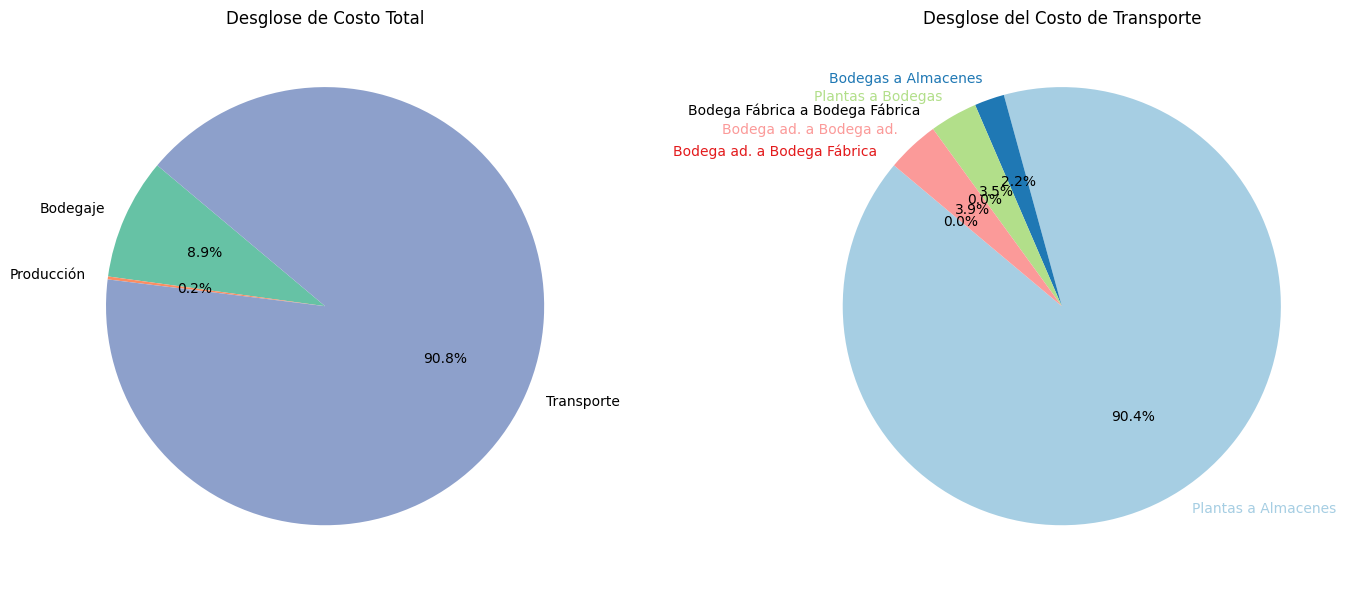

In [94]:
# Primer gráfico: desglose de costo_total en bodegaje, producción y transporte
labels_total = ['Bodegaje', 'Producción', 'Transporte']
sizes_total = [costo_total_bodegaje, costo_total_produccion, costo_total_tpte]
colors_total = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(14, 6))

# Primer gráfico: desglose de costo total
plt.subplot(1, 2, 1)
plt.pie(sizes_total, labels=labels_total, autopct='%1.1f%%', startangle=140, colors=colors_total)
plt.title('Desglose de Costo Total')

# Segundo gráfico: desglose de costo_total_tpte en subcategorías de transporte
labels_tpte = [
    'Plantas a Almacenes', 
    'Bodegas a Almacenes', 
    'Plantas a Bodegas', 
    'Bodega Fábrica a Bodega Fábrica', 
    'Bodega ad. a Bodega ad.', 
    'Bodega ad. a Bodega Fábrica'
]
sizes_tpte = [
    costo_neto_fabricas_demandas, 
    costo_neto_bodegas_demandas, 
    costo_neto_fabricas_bodegas, 
    costo_neto_prod_prod, 
    costo_neto_bod_bod,
    costo_neto_bod_bod_fabrica  # Nuevo costo
]
colors_tpte = ['#a6cee3', '#1f78b4', '#b2df8a', '#000000', '#fb9a99', '#e31a1c']  # 'Bodega Fábrica a Bodega Fábrica' es negro

plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(sizes_tpte, labels=labels_tpte, autopct='%1.1f%%', startangle=140, colors=colors_tpte)
plt.title('Desglose del Costo de Transporte')

# Ajuste de los colores de las etiquetas
for text, color in zip(texts, colors_tpte):
    text.set_color(color)

# Detalle de las nuevas utilidades
print(f"Los costos totales son: {costo_total_tpte + costo_total_produccion + costo_total_bodegaje}")
utilidades = ganancia - (costo_total_tpte + costo_total_produccion + costo_total_bodegaje)
print(f"Las utilidades son: {utilidades}")

plt.tight_layout()
plt.show()

In [95]:
cambio = (23029610.0 - 22478602.0)/22478602.0

if cambio > 0:
    print(f"Las utilidades subieron un {(cambio*100)}%")
else: 
    print(f"Las utilidades bajaron un {(cambio*100)}%")

Las utilidades subieron un 2.4512556430333166%


### Abrir las siguientes dos bodegas de menor costo fijo

Abriremos la 5 y la 15 y agregaremos la 1 la 2, esto se escogió arbitrariamente ya que existen muchas bodegas con el mismo costos fijo que la 1 y la 2

In [96]:
bodega_en_uso = [True, True, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False]

G4, sol4 = tantear_bodega (bodega_en_uso)

for a in sol4:
    if ('P' in a) and ('P_aux' not in a) and ('P_bod' not in a):
        nodo_productor = a.split(', ')[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        agregar_oferta = oferta_min_proveedores.loc[nodo_productor][f'{periodo}']
        
        oferta_acuatlizada = list(sol4[a].values())[0] + agregar_oferta

        sol4[a][list(sol4[a].keys())[0]] = oferta_acuatlizada

        if sum(list(sol4[a].values())) != oferta_max_proveedores.loc[nodo_productor][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

for a in sol4:
    if ('D' in a) and ('D_aux' not in a):
        nodo_demandado = a.split(', ')[0]
        nodo_demandon = list(sol4[a].keys())[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        quitar_demanda = demanda_min.loc[nodo_demandado][f'{periodo}']
        demanda_acuatlizada = list(sol4[a].values())[0] - quitar_demanda

        sol4[a][list(sol4[a].keys())[0]] = demanda_acuatlizada
        
        if list(sol4[a].values())[0] + sol4['Sumidero'][nodo_demandon] != demanda_max.loc[nodo_demandado][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

782
La suma de las demandas es: 0


In [97]:
(costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas, 
 costo_neto_prod_prod, costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte) = calcular_costos_tpte2(sol4)

Costo de transporte desde plantas a almacenes: 3770091.0
Costo de transporte desde bodegas a almacenes: 150101.0
Costo de transporte desde plantas a bodegas: 323651.0
Costo de transporte entre fábricas: 0
Costo de transporte entre bodegas: 313494.0
Costo de transporte desde bodegas adicionales a bodegas de fábrica: 0
Costo total: 4557337.0
Ganancia total: 28471910


In [98]:
costo_neto_bodegaje_en_fabricas, costo_neto_bodegaje_en_bodegas_ad, costo_total_bodegas_ad = calcular_costos_bodegaje2(G4, sol4, costo_fijo_bodega_adicional, bodega_en_uso)
costo_total_bodegaje = costo_neto_bodegaje_en_fabricas + costo_neto_bodegaje_en_bodegas_ad + costo_total_bodegas_ad

El costo total de bodegas adicionales es: 1000000
El costo neto de bodegaje en fábricas es: 1913
El costo neto de bodegaje en bodegas adicionales es: 836
El costo total de bodegaje: 1002749


In [99]:
costo_total_produccion = calcular_costo_produccion2(G3, sol4)

Costos de producción: 9681


Los costos totales son 5569767.0
Las utilidades son: 22902143.0


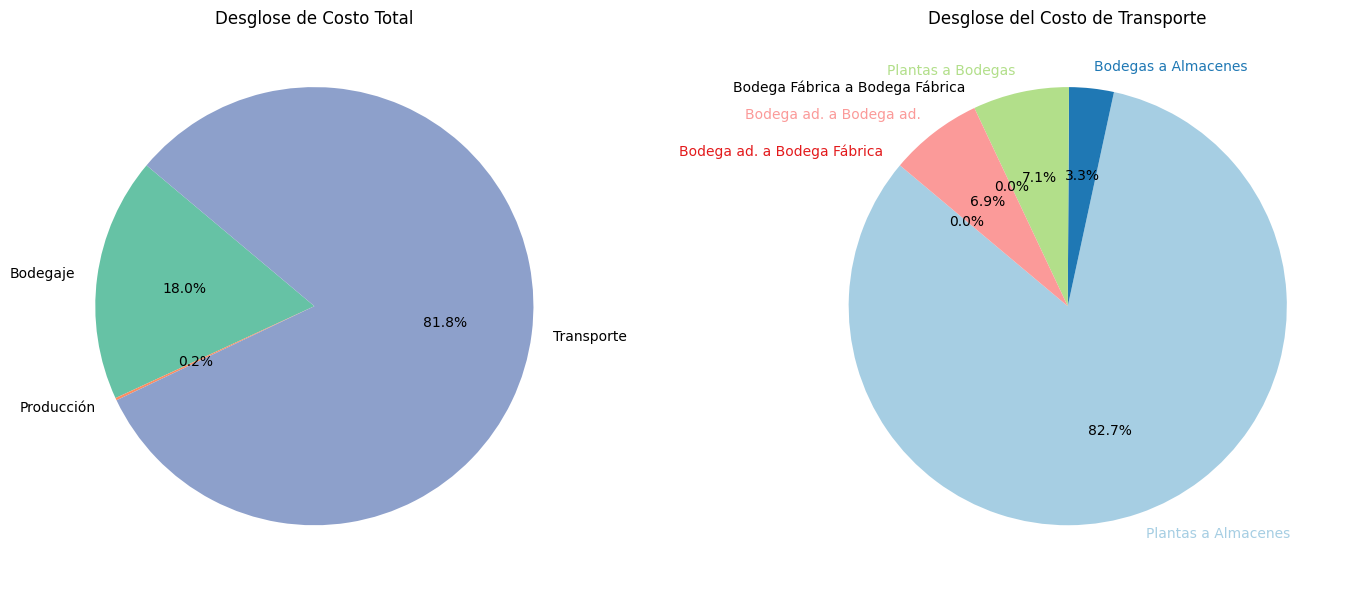

In [100]:
# Primer gráfico: desglose de costo_total en bodegaje, producción y transporte
labels_total = ['Bodegaje', 'Producción', 'Transporte']
sizes_total = [costo_total_bodegaje, costo_total_produccion, costo_total_tpte]
colors_total = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(14, 6))

# Primer gráfico: desglose de costo total
plt.subplot(1, 2, 1)
plt.pie(sizes_total, labels=labels_total, autopct='%1.1f%%', startangle=140, colors=colors_total)
plt.title('Desglose de Costo Total')

# Segundo gráfico: desglose de costo_total_tpte en subcategorías de transporte
labels_tpte = [
    'Plantas a Almacenes', 
    'Bodegas a Almacenes', 
    'Plantas a Bodegas', 
    'Bodega Fábrica a Bodega Fábrica', 
    'Bodega ad. a Bodega ad.', 
    'Bodega ad. a Bodega Fábrica'
]
sizes_tpte = [
    costo_neto_fabricas_demandas, 
    costo_neto_bodegas_demandas, 
    costo_neto_fabricas_bodegas, 
    costo_neto_prod_prod, 
    costo_neto_bod_bod,
    costo_neto_bod_bod_fabrica  # Nuevo costo
]
colors_tpte = ['#a6cee3', '#1f78b4', '#b2df8a', '#000000', '#fb9a99', '#e31a1c']  # 'Bodega Fábrica a Bodega Fábrica' es negro

plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(sizes_tpte, labels=labels_tpte, autopct='%1.1f%%', startangle=140, colors=colors_tpte)
plt.title('Desglose del Costo de Transporte')

# Ajuste de los colores de las etiquetas
for text, color in zip(texts, colors_tpte):
    text.set_color(color)

# Detalle de las nuevas utilidades
print(f"Los costos totales son {costo_total_tpte + costo_total_produccion + costo_total_bodegaje}")
utilidades = ganancia - (costo_total_tpte + costo_total_produccion + costo_total_bodegaje)
print(f"Las utilidades son: {utilidades}")

plt.tight_layout()
plt.show()

In [101]:
cambio = (23011878.0 - 22478602.0)/22478602.0

if cambio > 0:
    print(f"Las utilidades subieron un {(cambio*100)}%")
else: 
    print(f"Las utilidades bajaron un {(cambio*100)}%")

Las utilidades subieron un 2.372371733793765%


### Abrir las dos bodegas de menor costo fijo y 1 de costo 300.0000

In [102]:
bodega_en_uso = [True, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False]

G5, sol5 = tantear_bodega (bodega_en_uso)

for a in sol5:
    if ('P' in a) and ('P_aux' not in a) and ('P_bod' not in a):
        nodo_productor = a.split(', ')[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        agregar_oferta = oferta_min_proveedores.loc[nodo_productor][f'{periodo}']
        
        oferta_acuatlizada = list(sol5[a].values())[0] + agregar_oferta

        sol5[a][list(sol5[a].keys())[0]] = oferta_acuatlizada

        if sum(list(sol5[a].values())) != oferta_max_proveedores.loc[nodo_productor][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

for a in sol5:
    if ('D' in a) and ('D_aux' not in a):
        nodo_demandado = a.split(', ')[0]
        nodo_demandon = list(sol5[a].keys())[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        quitar_demanda = demanda_min.loc[nodo_demandado][f'{periodo}']
        demanda_acuatlizada = list(sol5[a].values())[0] - quitar_demanda

        sol5[a][list(sol5[a].keys())[0]] = demanda_acuatlizada
        
        if list(sol5[a].values())[0] + sol5['Sumidero'][nodo_demandon] != demanda_max.loc[nodo_demandado][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

802
La suma de las demandas es: 0


In [103]:
(costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas, 
 costo_neto_prod_prod, costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte) = calcular_costos_tpte2(sol5)

Costo de transporte desde plantas a almacenes: 3705518.0
Costo de transporte desde bodegas a almacenes: 136314.0
Costo de transporte desde plantas a bodegas: 265264.0
Costo de transporte entre fábricas: 0
Costo de transporte entre bodegas: 202192.0
Costo de transporte desde bodegas adicionales a bodegas de fábrica: 0
Costo total: 4309288.0
Ganancia total: 28025310


In [104]:
costo_total_produccion = calcular_costo_produccion2(G5, sol5)

Costos de producción: 9681


In [105]:
costo_neto_bodegaje_en_fabricas, costo_neto_bodegaje_en_bodegas_ad, costo_total_bodegas_ad = calcular_costos_bodegaje2(G5, sol5, costo_fijo_bodega_adicional, bodega_en_uso)
costo_total_bodegaje = costo_neto_bodegaje_en_fabricas + costo_neto_bodegaje_en_bodegas_ad + costo_total_bodegas_ad

El costo total de bodegas adicionales es: 700000
El costo neto de bodegaje en fábricas es: 1913
El costo neto de bodegaje en bodegas adicionales es: 634
El costo total de bodegaje: 702547


Los costos totales son 5021516.0
Las utilidades son: 23003794.0


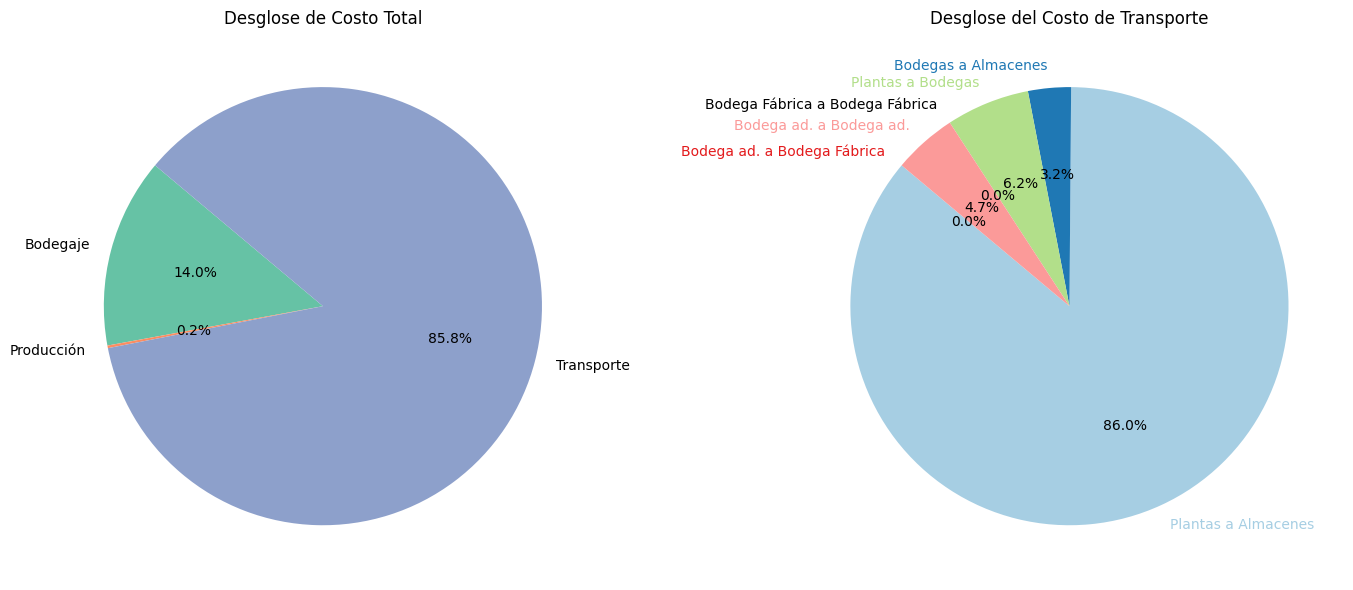

In [106]:
# Primer gráfico: desglose de costo_total en bodegaje, producción y transporte
labels_total = ['Bodegaje', 'Producción', 'Transporte']
sizes_total = [costo_total_bodegaje, costo_total_produccion, costo_total_tpte]
colors_total = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(14, 6))

# Primer gráfico: desglose de costo total
plt.subplot(1, 2, 1)
plt.pie(sizes_total, labels=labels_total, autopct='%1.1f%%', startangle=140, colors=colors_total)
plt.title('Desglose de Costo Total')

# Segundo gráfico: desglose de costo_total_tpte en subcategorías de transporte
labels_tpte = [
    'Plantas a Almacenes', 
    'Bodegas a Almacenes', 
    'Plantas a Bodegas', 
    'Bodega Fábrica a Bodega Fábrica', 
    'Bodega ad. a Bodega ad.', 
    'Bodega ad. a Bodega Fábrica'
]
sizes_tpte = [
    costo_neto_fabricas_demandas, 
    costo_neto_bodegas_demandas, 
    costo_neto_fabricas_bodegas, 
    costo_neto_prod_prod, 
    costo_neto_bod_bod,
    costo_neto_bod_bod_fabrica  # Nuevo costo
]
colors_tpte = ['#a6cee3', '#1f78b4', '#b2df8a', '#000000', '#fb9a99', '#e31a1c']  # 'Bodega Fábrica a Bodega Fábrica' es negro

plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(sizes_tpte, labels=labels_tpte, autopct='%1.1f%%', startangle=140, colors=colors_tpte)
plt.title('Desglose del Costo de Transporte')

# Ajuste de los colores de las etiquetas
for text, color in zip(texts, colors_tpte):
    text.set_color(color)

# Detalle de las nuevas utilidades
print(f"Los costos totales son {costo_total_tpte + costo_total_produccion + costo_total_bodegaje}")
utilidades = ganancia - (costo_total_tpte + costo_total_produccion + costo_total_bodegaje)
print(f"Las utilidades son: {utilidades}")

plt.tight_layout()
plt.show()

In [107]:
cambio = (23012080.0 - 22478602.0)/22478602.0

if cambio > 0:
    print(f"Las utilidades subieron un {(cambio*100)}%")
else: 
    print(f"Las utilidades bajaron un {(cambio*100)}%")

Las utilidades subieron un 2.3732703661909222%


### Abrir solo una bodega de menor costo fijo

Probemos con la 5

In [108]:
bodega_en_uso = [False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False]

G6, sol6 = tantear_bodega (bodega_en_uso)

for a in sol6:
    if ('P' in a) and ('P_aux' not in a) and ('P_bod' not in a):
        nodo_productor = a.split(', ')[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        agregar_oferta = oferta_min_proveedores.loc[nodo_productor][f'{periodo}']
        
        oferta_acuatlizada = list(sol6[a].values())[0] + agregar_oferta

        sol6[a][list(sol6[a].keys())[0]] = oferta_acuatlizada

        if sum(list(sol6[a].values())) != oferta_max_proveedores.loc[nodo_productor][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

for a in sol6:
    if ('D' in a) and ('D_aux' not in a):
        nodo_demandado = a.split(', ')[0]
        nodo_demandon = list(sol6[a].keys())[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        quitar_demanda = demanda_min.loc[nodo_demandado][f'{periodo}']
        demanda_acuatlizada = list(sol6[a].values())[0] - quitar_demanda

        sol6[a][list(sol6[a].keys())[0]] = demanda_acuatlizada
        
        if list(sol6[a].values())[0] + sol6['Sumidero'][nodo_demandon] != demanda_max.loc[nodo_demandado][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

952
La suma de las demandas es: 0


In [109]:
(costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas, 
 costo_neto_prod_prod, costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte) = calcular_costos_tpte2(sol6)

Costo de transporte desde plantas a almacenes: 3633755.0
Costo de transporte desde bodegas a almacenes: 77160.0
Costo de transporte desde plantas a bodegas: 130624.0
Costo de transporte entre fábricas: 0
Costo de transporte entre bodegas: 0.0
Costo de transporte desde bodegas adicionales a bodegas de fábrica: 0
Costo total: 3841539.0
Ganancia total: 27068310


In [110]:
costo_total_produccion = calcular_costo_produccion2(G6, sol6)

Costos de producción: 9681


In [111]:
costo_neto_bodegaje_en_fabricas, costo_neto_bodegaje_en_bodegas_ad, costo_total_bodegas_ad = calcular_costos_bodegaje2(G6, sol6, costo_fijo_bodega_adicional, bodega_en_uso)
costo_total_bodegaje = costo_neto_bodegaje_en_fabricas + costo_neto_bodegaje_en_bodegas_ad + costo_total_bodegas_ad

El costo total de bodegas adicionales es: 200000
El costo neto de bodegaje en fábricas es: 1913
El costo neto de bodegaje en bodegas adicionales es: 218
El costo total de bodegaje: 202131


Los costos totales son 4053351.0
Las utilidades son: 23014959.0


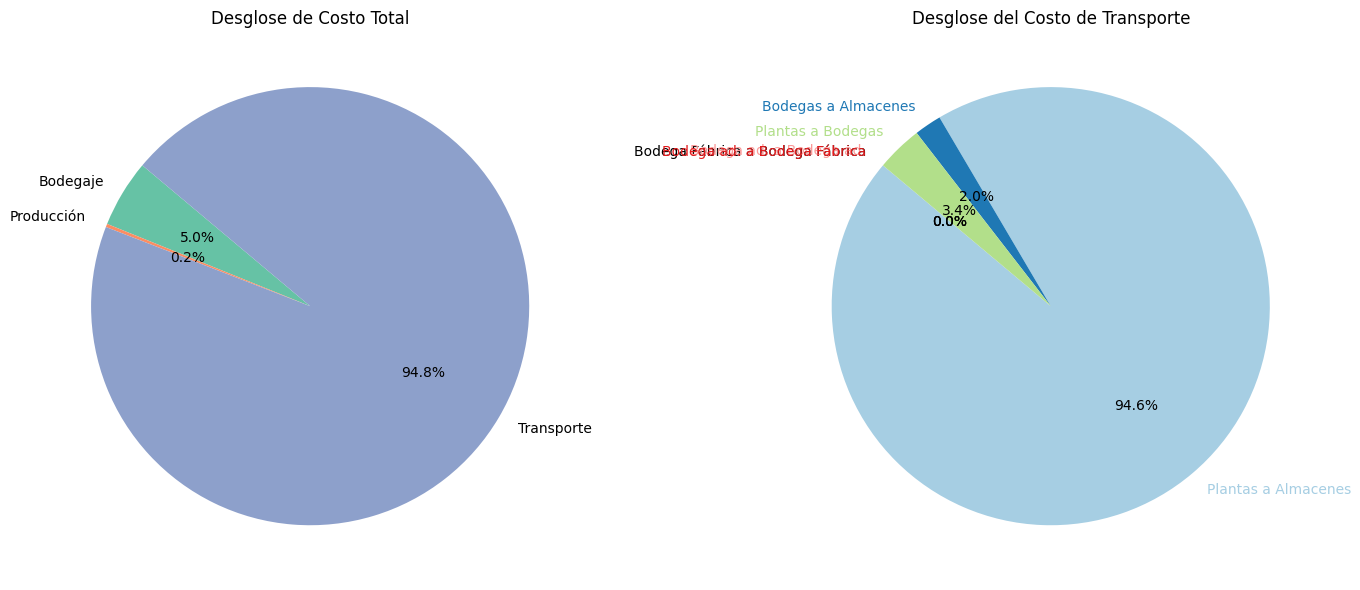

In [112]:
# Primer gráfico: desglose de costo_total en bodegaje, producción y transporte
labels_total = ['Bodegaje', 'Producción', 'Transporte']
sizes_total = [costo_total_bodegaje, costo_total_produccion, costo_total_tpte]
colors_total = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(14, 6))

# Primer gráfico: desglose de costo total
plt.subplot(1, 2, 1)
plt.pie(sizes_total, labels=labels_total, autopct='%1.1f%%', startangle=140, colors=colors_total)
plt.title('Desglose de Costo Total')

# Segundo gráfico: desglose de costo_total_tpte en subcategorías de transporte
labels_tpte = [
    'Plantas a Almacenes', 
    'Bodegas a Almacenes', 
    'Plantas a Bodegas', 
    'Bodega Fábrica a Bodega Fábrica', 
    'Bodega ad. a Bodega ad.', 
    'Bodega ad. a Bodega Fábrica'
]
sizes_tpte = [
    costo_neto_fabricas_demandas, 
    costo_neto_bodegas_demandas, 
    costo_neto_fabricas_bodegas, 
    costo_neto_prod_prod, 
    costo_neto_bod_bod,
    costo_neto_bod_bod_fabrica  # Nuevo costo
]
colors_tpte = ['#a6cee3', '#1f78b4', '#b2df8a', '#000000', '#fb9a99', '#e31a1c']  # 'Bodega Fábrica a Bodega Fábrica' es negro

plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(sizes_tpte, labels=labels_tpte, autopct='%1.1f%%', startangle=140, colors=colors_tpte)
plt.title('Desglose del Costo de Transporte')

# Ajuste de los colores de las etiquetas
for text, color in zip(texts, colors_tpte):
    text.set_color(color)

# Detalle de las nuevas utilidades
print(f"Los costos totales son {costo_total_tpte + costo_total_produccion + costo_total_bodegaje}")
utilidades = ganancia - (costo_total_tpte + costo_total_produccion + costo_total_bodegaje)
print(f"Las utilidades son: {utilidades}")

plt.tight_layout()
plt.show()

In [113]:
cambio = (23009958.0 - 22478602.0)/22478602.0

if cambio > 0:
    print(f"Las utilidades subieron un {(cambio*100)}%")
else: 
    print(f"Las utilidades bajaron un {(cambio*100)}%")

Las utilidades subieron un 2.3638302773455395%


Probemos con la 15

In [114]:
bodega_en_uso = [False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False]

G7, sol7 = tantear_bodega (bodega_en_uso)

for a in sol7:
    if ('P' in a) and ('P_aux' not in a) and ('P_bod' not in a):
        nodo_productor = a.split(', ')[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        agregar_oferta = oferta_min_proveedores.loc[nodo_productor][f'{periodo}']
        
        oferta_acuatlizada = list(sol7[a].values())[0] + agregar_oferta

        sol7[a][list(sol7[a].keys())[0]] = oferta_acuatlizada

        if sum(list(sol7[a].values())) != oferta_max_proveedores.loc[nodo_productor][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

for a in sol7:
    if ('D' in a) and ('D_aux' not in a):
        nodo_demandado = a.split(', ')[0]
        nodo_demandon = list(sol7[a].keys())[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        quitar_demanda = demanda_min.loc[nodo_demandado][f'{periodo}']
        demanda_acuatlizada = list(sol7[a].values())[0] - quitar_demanda

        sol7[a][list(sol7[a].keys())[0]] = demanda_acuatlizada
        
        if list(sol7[a].values())[0] + sol7['Sumidero'][nodo_demandon] != demanda_max.loc[nodo_demandado][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

1002
La suma de las demandas es: 0


In [115]:
(costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas, 
 costo_neto_prod_prod, costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte) = calcular_costos_tpte2(sol7)

Costo de transporte desde plantas a almacenes: 3692694.0
Costo de transporte desde bodegas a almacenes: 9514.0
Costo de transporte desde plantas a bodegas: 36357.0
Costo de transporte entre fábricas: 0
Costo de transporte entre bodegas: 159503.0
Costo de transporte desde bodegas adicionales a bodegas de fábrica: 0
Costo total: 3898068.0
Ganancia total: 26745540


In [116]:
costo_total_produccion = calcular_costo_produccion2(G7, sol7)

Costos de producción: 9681


In [117]:
costo_neto_bodegaje_en_fabricas, costo_neto_bodegaje_en_bodegas_ad, costo_total_bodegas_ad = calcular_costos_bodegaje2(G6, sol6, costo_fijo_bodega_adicional, bodega_en_uso)
costo_total_bodegaje = costo_neto_bodegaje_en_fabricas + costo_neto_bodegaje_en_bodegas_ad + costo_total_bodegas_ad

El costo total de bodegas adicionales es: 200000
El costo neto de bodegaje en fábricas es: 1913
El costo neto de bodegaje en bodegas adicionales es: 218
El costo total de bodegaje: 202131


Los costos totales son 4109880.0
Las utilidades son: 22635660.0


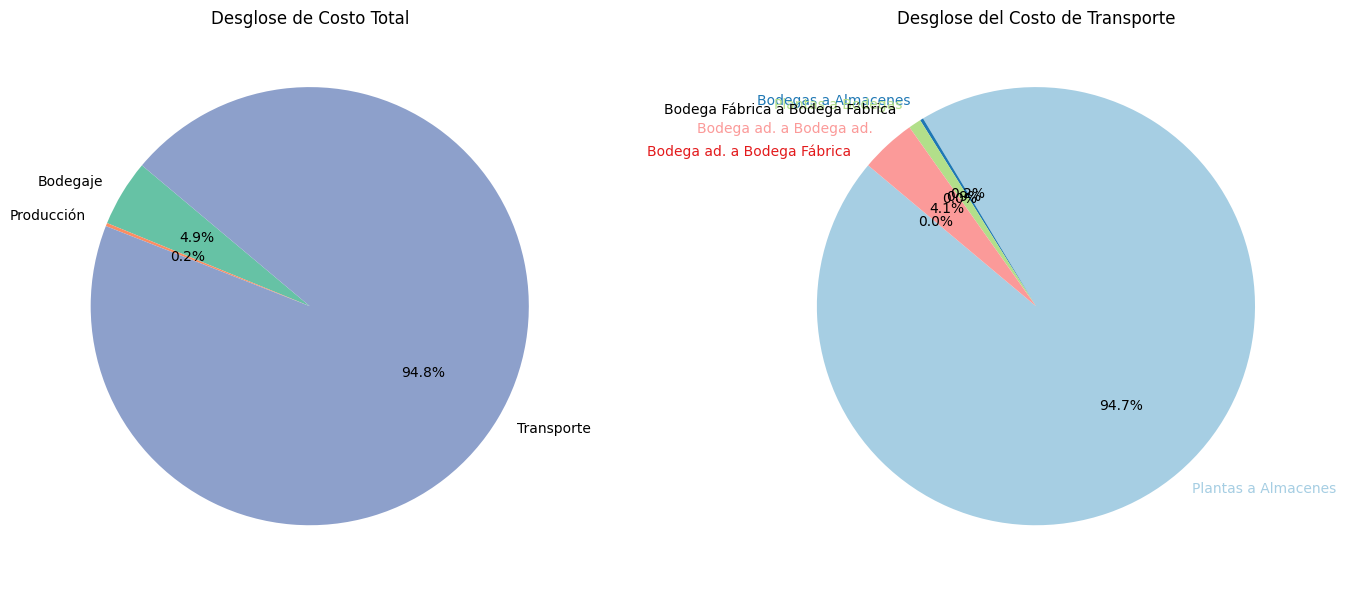

In [118]:
# Primer gráfico: desglose de costo_total en bodegaje, producción y transporte
labels_total = ['Bodegaje', 'Producción', 'Transporte']
sizes_total = [costo_total_bodegaje, costo_total_produccion, costo_total_tpte]
colors_total = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(14, 6))

# Primer gráfico: desglose de costo total
plt.subplot(1, 2, 1)
plt.pie(sizes_total, labels=labels_total, autopct='%1.1f%%', startangle=140, colors=colors_total)
plt.title('Desglose de Costo Total')

# Segundo gráfico: desglose de costo_total_tpte en subcategorías de transporte
labels_tpte = [
    'Plantas a Almacenes', 
    'Bodegas a Almacenes', 
    'Plantas a Bodegas', 
    'Bodega Fábrica a Bodega Fábrica', 
    'Bodega ad. a Bodega ad.', 
    'Bodega ad. a Bodega Fábrica'
]
sizes_tpte = [
    costo_neto_fabricas_demandas, 
    costo_neto_bodegas_demandas, 
    costo_neto_fabricas_bodegas, 
    costo_neto_prod_prod, 
    costo_neto_bod_bod,
    costo_neto_bod_bod_fabrica  # Nuevo costo
]
colors_tpte = ['#a6cee3', '#1f78b4', '#b2df8a', '#000000', '#fb9a99', '#e31a1c']  # 'Bodega Fábrica a Bodega Fábrica' es negro

plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(sizes_tpte, labels=labels_tpte, autopct='%1.1f%%', startangle=140, colors=colors_tpte)
plt.title('Desglose del Costo de Transporte')

# Ajuste de los colores de las etiquetas
for text, color in zip(texts, colors_tpte):
    text.set_color(color)

# Detalle de las nuevas utilidades
print(f"Los costos totales son {costo_total_tpte + costo_total_produccion + costo_total_bodegaje}")
utilidades = ganancia - (costo_total_tpte + costo_total_produccion + costo_total_bodegaje)
print(f"Las utilidades son: {utilidades}")

plt.tight_layout()
plt.show()

In [119]:
cambio = (22632008.0-22478602.0)/22478602.0

if cambio > 0:
    print(f"Las utilidades subieron un {(cambio*100)}%")
else: 
    print(f"Las utilidades bajaron un {(cambio*100)}%")

Las utilidades subieron un 0.6824534728627697%


### Probemos el otro extremo: Abrir todas las bodegas

In [120]:
bodega_en_uso = [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]

G8, sol8 = tantear_bodega (bodega_en_uso)

for a in sol8:
    if ('P' in a) and ('P_aux' not in a) and ('P_bod' not in a):
        nodo_productor = a.split(', ')[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        agregar_oferta = oferta_min_proveedores.loc[nodo_productor][f'{periodo}']
        
        oferta_acuatlizada = list(sol8[a].values())[0] + agregar_oferta

        sol8[a][list(sol8[a].keys())[0]] = oferta_acuatlizada

        if sum(list(sol8[a].values())) != oferta_max_proveedores.loc[nodo_productor][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

for a in sol8:
    if ('D' in a) and ('D_aux' not in a):
        nodo_demandado = a.split(', ')[0]
        nodo_demandon = list(sol8[a].keys())[0]
        periodo =  extraer_numeros(a.split(', ')[1])[0]
        quitar_demanda = demanda_min.loc[nodo_demandado][f'{periodo}']
        demanda_acuatlizada = list(sol8[a].values())[0] - quitar_demanda

        sol8[a][list(sol8[a].keys())[0]] = demanda_acuatlizada
        
        if list(sol8[a].values())[0] + sol8['Sumidero'][nodo_demandon] != demanda_max.loc[nodo_demandado][f'{periodo}']:
            print('devolviendo mal las cotas minimas')

168
La suma de las demandas es: 0


In [121]:
(costo_neto_fabricas_demandas, costo_neto_bodegas_demandas, costo_neto_fabricas_bodegas, 
 costo_neto_prod_prod, costo_neto_bod_bod, costo_neto_bod_bod_fabrica, ganancia, costo_total_tpte) = calcular_costos_tpte2(sol8)

Costo de transporte desde plantas a almacenes: 3562248.0
Costo de transporte desde bodegas a almacenes: 299315.0
Costo de transporte desde plantas a bodegas: 606960.0
Costo de transporte entre fábricas: 0
Costo de transporte entre bodegas: 821252.0
Costo de transporte desde bodegas adicionales a bodegas de fábrica: 0.0
Costo total: 5289775.0
Ganancia total: 29825570


In [122]:
costo_total_produccion = calcular_costo_produccion2(G8, sol8)

Costos de producción: 9681


In [123]:
costo_neto_bodegaje_en_fabricas, costo_neto_bodegaje_en_bodegas_ad, costo_total_bodegas_ad = calcular_costos_bodegaje2(G6, sol6, costo_fijo_bodega_adicional, bodega_en_uso)
costo_total_bodegaje = costo_neto_bodegaje_en_fabricas + costo_neto_bodegaje_en_bodegas_ad + costo_total_bodegas_ad

El costo total de bodegas adicionales es: 5700000
El costo neto de bodegaje en fábricas es: 1913
El costo neto de bodegaje en bodegas adicionales es: 218
El costo total de bodegaje: 5702131


Los costos totales son 11001587.0
Las utilidades son: 18823983.0


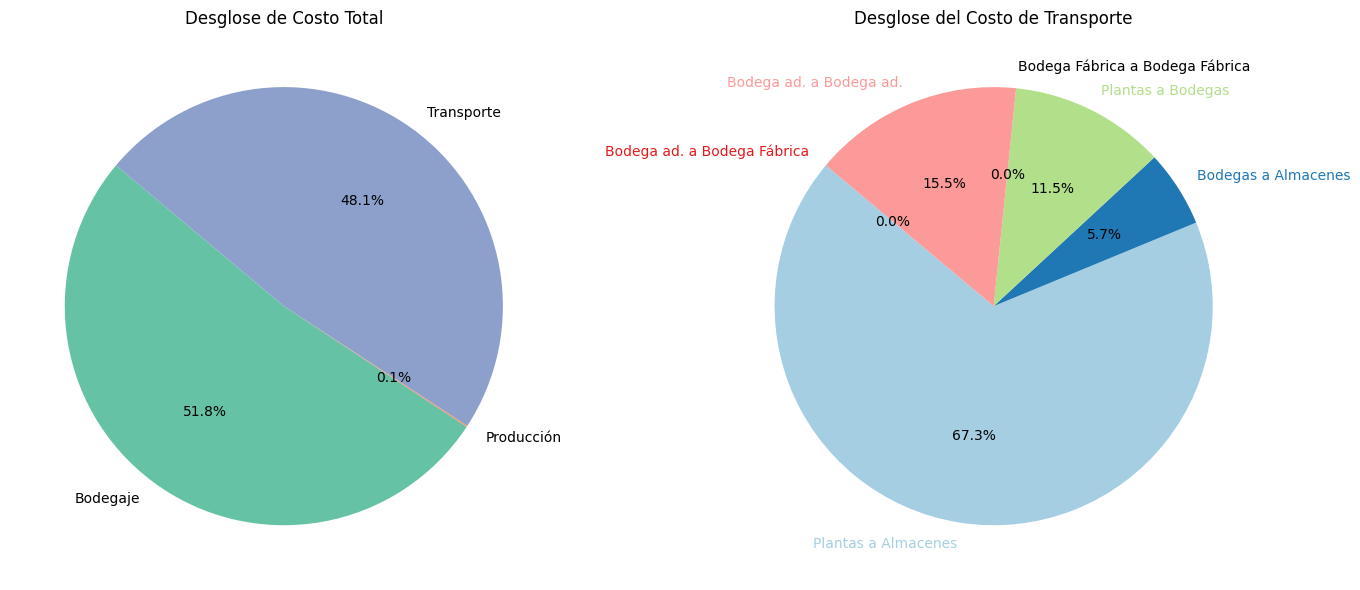

In [124]:
# Primer gráfico: desglose de costo_total en bodegaje, producción y transporte
labels_total = ['Bodegaje', 'Producción', 'Transporte']
sizes_total = [costo_total_bodegaje, costo_total_produccion, costo_total_tpte]
colors_total = ['#66c2a5', '#fc8d62', '#8da0cb']

plt.figure(figsize=(14, 6))

# Primer gráfico: desglose de costo total
plt.subplot(1, 2, 1)
plt.pie(sizes_total, labels=labels_total, autopct='%1.1f%%', startangle=140, colors=colors_total)
plt.title('Desglose de Costo Total')

# Segundo gráfico: desglose de costo_total_tpte en subcategorías de transporte
labels_tpte = [
    'Plantas a Almacenes', 
    'Bodegas a Almacenes', 
    'Plantas a Bodegas', 
    'Bodega Fábrica a Bodega Fábrica', 
    'Bodega ad. a Bodega ad.', 
    'Bodega ad. a Bodega Fábrica'
]
sizes_tpte = [
    costo_neto_fabricas_demandas, 
    costo_neto_bodegas_demandas, 
    costo_neto_fabricas_bodegas, 
    costo_neto_prod_prod, 
    costo_neto_bod_bod,
    costo_neto_bod_bod_fabrica  # Nuevo costo
]
colors_tpte = ['#a6cee3', '#1f78b4', '#b2df8a', '#000000', '#fb9a99', '#e31a1c']  # 'Bodega Fábrica a Bodega Fábrica' es negro

plt.subplot(1, 2, 2)
patches, texts, autotexts = plt.pie(sizes_tpte, labels=labels_tpte, autopct='%1.1f%%', startangle=140, colors=colors_tpte)
plt.title('Desglose del Costo de Transporte')

# Ajuste de los colores de las etiquetas
for text, color in zip(texts, colors_tpte):
    text.set_color(color)

# Detalle de las nuevas utilidades
print(f"Los costos totales son {costo_total_tpte + costo_total_produccion + costo_total_bodegaje}")
utilidades = ganancia - (costo_total_tpte + costo_total_produccion + costo_total_bodegaje)
print(f"Las utilidades son: {utilidades}")

plt.tight_layout()
plt.show()

In [125]:
cambio = (18797953.0-22478602.0)/22478602.0

if cambio > 0:
    print(f"Las utilidades subieron un {(cambio*100)}%")
else: 
    print(f"Las utilidades bajaron un {(cambio*100)}%")

Las utilidades bajaron un -16.37401204932584%
